In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Installing fifty regex tqdm clip 


In [4]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jqhucm4k
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-jqhucm4k
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 

In [5]:
# Download once (run in separate cell):
!wget https://s3.amazonaws.com/conceptnet/downloads/2019/edges/conceptnet-assertions-5.7.0.csv.gz
!gunzip conceptnet-assertions-5.7.0.csv.gz

import pandas as pd

class LocalConceptNetRetriever:
    """Query ConceptNet locally from downloaded CSV"""
    
    def __init__(self, csv_path='conceptnet-assertions-5.7.0.csv', max_triples=5):
        print("Loading ConceptNet locally (this may take 1-2 minutes)...")
        # Load only English relations
        self.df = pd.read_csv(
            csv_path, 
            sep='\t', 
            header=None,
            names=['uri', 'relation', 'start', 'end', 'metadata'],
            usecols=['relation', 'start', 'end']
        )
        # Filter English only
        self.df = self.df[
            self.df['start'].str.contains('/c/en/') & 
            self.df['end'].str.contains('/c/en/')
        ]
        print(f"✓ Loaded {len(self.df):,} English ConceptNet triples")
        self.max_triples = max_triples
        self.cache = {}
    
    def _clean_concept(self, uri):
        """Extract clean word from URI like '/c/en/dog/n' -> 'dog'"""
        try:
            return uri.split('/')[3]
        except:
            return uri
    
    def get_related_concepts(self, word, limit=5):
        """Get related concepts from local ConceptNet"""
        word = word.lower().strip()
        
        if word in self.cache:
            return self.cache[word]
        
        # Query local dataframe
        query_pattern = f'/c/en/{word}'
        matches = self.df[
            self.df['start'].str.contains(query_pattern, case=False, na=False) |
            self.df['end'].str.contains(query_pattern, case=False, na=False)
        ].head(limit)
        
        triples = []
        for _, row in matches.iterrows():
            start = self._clean_concept(row['start'])
            rel = self._clean_concept(row['relation'])
            end = self._clean_concept(row['end'])
            triples.append(f"{start} {rel} {end}")
        
        self.cache[word] = triples
        return triples
    
    def extract_key_words(self, text):
        """Extract key words from text"""
        words = text.lower().split()
        stopwords = {'a', 'an', 'the', 'is', 'are', 'what', 'how', 'where', 'who', 'in', 'on', 'at'}
        key_words = [w.strip('?.,!') for w in words if w not in stopwords and len(w) > 2]
        return key_words[:3]
    
    def get_knowledge_for_question(self, question):
        """Get ConceptNet knowledge for a question"""
        key_words = self.extract_key_words(question)
        all_triples = []
        
        for word in key_words:
            triples = self.get_related_concepts(word, limit=2)
            all_triples.extend(triples)
        
        return all_triples[:self.max_triples]

--2025-11-24 13:42:02--  https://s3.amazonaws.com/conceptnet/downloads/2019/edges/conceptnet-assertions-5.7.0.csv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.199.164, 52.217.98.214, 16.15.204.244, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.199.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 497963447 (475M) [application/x-gzip]
Saving to: ‘conceptnet-assertions-5.7.0.csv.gz’

conceptnet-assertio 100%[===================>] 474.89M  16.9MB/s    in 30s     

2025-11-24 13:42:32 (15.9 MB/s) - ‘conceptnet-assertions-5.7.0.csv.gz’ saved [497963447/497963447]



In [6]:
!gunzip conceptnet-assertions-5.7.0.csv.gz


gzip: conceptnet-assertions-5.7.0.csv.gz: No such file or directory


## POC for new architecture to see whether it has potential of learning
Synthetic VQA on Flickr8k - we generates synthetic question-answer pairs from image captions, uses local ConceptNet for knowledge retrieval, trains a two-stage attention model to answer simple questions.

Key points:
1. Synthetic dataset: Auto-generates Q&A pairs from captions, let's say caption is: "A brown dog running in the garden" -> Q1: What is the colour of the dog; A: Brown, Q2: "Is there a dog?" → A: "yes"
2. Local kG ConceptNet retreival
3. Only 25 answer classes/vocab (yes/no/person/dog/colors/numbers)- based on these words we choose the captions or vice versa 
4. Quick prototype to test the architecture before using real VQA datasets

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import clip
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm
import numpy as np

# --- 0. Setup and Hyperparameters ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Paths
IMAGE_DIR = "/kaggle/input/flickr8k/Images"
CAPTION_FILE = "/kaggle/input/flickr8k/captions.txt"
CONCEPTNET_PATH = "/kaggle/working/conceptnet-assertions-5.7.0.csv"  # Path to unzipped file

# Model Hyperparameters
batch_size = 64
clip_embed_dim = 512
kg_embed_dim = 300
num_heads = 8
max_kg_triples = 5

# Training Hyperparameters
num_epochs = 10
learning_rate = 1e-4
max_images = 2000

# Answer vocabulary
ANSWER_VOCAB = ['yes', 'no', 'person', 'people', 'dog', 'cat', 'child', 'man', 'woman', 
                'outside', 'inside', 'playing', 'running', 'standing', 'sitting',
                'red', 'blue', 'green', 'black', 'white', 'brown',
                'one', 'two', 'three', 'many', 'none']
ANSWER_TO_IDX = {ans: idx for idx, ans in enumerate(ANSWER_VOCAB)}
IDX_TO_ANSWER = {idx: ans for ans, idx in ANSWER_TO_IDX.items()}

print(f"Answer vocabulary size: {len(ANSWER_VOCAB)}")


# --- 1. LOCAL ConceptNet Knowledge Retrieval ---
class LocalConceptNetRetriever:
    """Retrieves knowledge triples from local ConceptNet CSV file"""
    
    def __init__(self, csv_path='conceptnet-assertions-5.7.0.csv', max_triples=5):
        print("\n" + "="*70)
        print("Loading ConceptNet locally (this may take 1-2 minutes)...")
        print("="*70)
        
        # Load CSV with proper column names
        self.df = pd.read_csv(
            csv_path, 
            sep='\t', 
            header=None,
            names=['uri', 'relation', 'start', 'end', 'json_data'],
            usecols=['relation', 'start', 'end'],
            on_bad_lines='skip'
        )
        
        print(f"Total triples loaded: {len(self.df):,}")
        
        # Filter for English concepts only
        print("Filtering English concepts...")
        self.df = self.df[
            self.df['start'].str.contains('/c/en/', na=False) & 
            self.df['end'].str.contains('/c/en/', na=False)
        ]
        
        print(f"✓ Loaded {len(self.df):,} English ConceptNet triples")
        print("="*70 + "\n")
        
        self.max_triples = max_triples
        self.cache = {}
    
    def _clean_concept(self, uri):
        """Extract clean word from URI like '/c/en/dog/n' -> 'dog'"""
        try:
            parts = uri.split('/')
            if len(parts) >= 4:
                return parts[3]
            return uri
        except:
            return uri
    
    def get_related_concepts(self, word, limit=5):
        """Get related concepts from local ConceptNet"""
        word = word.lower().strip()
        
        # Check cache first
        if word in self.cache:
            return self.cache[word]
        
        # Query local dataframe
        query_pattern = f'/c/en/{word}'
        
        # Find rows where the word appears in start OR end
        matches = self.df[
            self.df['start'].str.contains(query_pattern, case=False, na=False, regex=False) |
            self.df['end'].str.contains(query_pattern, case=False, na=False, regex=False)
        ].head(limit)
        
        triples = []
        for _, row in matches.iterrows():
            start = self._clean_concept(row['start'])
            rel = self._clean_concept(row['relation'])
            end = self._clean_concept(row['end'])
            
            if start and rel and end:
                triples.append(f"{start} {rel} {end}")
        
        # Cache the result
        self.cache[word] = triples
        return triples
    
    def extract_key_words(self, text):
        """Extract key nouns/verbs from text"""
        words = text.lower().split()
        stopwords = {'a', 'an', 'the', 'is', 'are', 'what', 'how', 'where', 'who', 'in', 'on', 'at', 'there'}
        key_words = [w.strip('?.,!') for w in words if w not in stopwords and len(w) > 2]
        return key_words[:3]
    
    def get_knowledge_for_question(self, question):
        """Get ConceptNet knowledge for a question"""
        key_words = self.extract_key_words(question)
        all_triples = []
        
        for word in key_words:
            triples = self.get_related_concepts(word, limit=2)
            all_triples.extend(triples)
        
        return all_triples[:self.max_triples]


# --- 2. Dataset Class ---
class VQADataset(Dataset):
    """Synthetic VQA dataset from Flickr8k captions"""
    
    def __init__(self, image_dir, caption_file, preprocess, clip_model, 
                 conceptnet_retriever, max_images=None):
        self.image_dir = image_dir
        self.preprocess = preprocess
        self.clip_model = clip_model
        self.conceptnet = conceptnet_retriever
        
        print(f"Loading captions from {caption_file}...")
        df = pd.read_csv(caption_file)
        
        # Group captions by image
        self.data = df.groupby('image')['caption'].apply(list).reset_index()
        
        if max_images:
            self.data = self.data.head(max_images)
        
        # Generate synthetic VQA pairs
        self.vqa_pairs = self._generate_vqa_pairs()
        
        print(f"✓ Generated {len(self.vqa_pairs)} VQA pairs from {len(self.data)} images.")
    
    def _generate_vqa_pairs(self):
        """Generate synthetic question-answer pairs from captions"""
        vqa_pairs = []
        
        question_templates = [
            ("Is there a {} in the image?", ["person", "dog", "child", "man", "woman"]),
            ("What is the person doing?", ["playing", "running", "standing", "sitting"]),
            ("Is this indoors or outdoors?", ["outside", "inside"]),
            ("How many people are there?", ["one", "two", "many", "none"]),
        ]
        
        for idx, row in self.data.iterrows():
            image_name = row['image']
            caption = row['caption'][0].lower()
            
            # Generate 2 QA pairs per image
            for template, possible_answers in question_templates[:2]:
                question = template.format(possible_answers[0]) if "{}" in template else template
                
                # Simple answer extraction from caption
                answer = "yes"
                for ans in possible_answers:
                    if ans in caption:
                        answer = ans
                        break
                else:
                    answer = possible_answers[0]
                
                if answer in ANSWER_TO_IDX:
                    vqa_pairs.append({
                        'image': image_name,
                        'question': question,
                        'answer': answer,
                        'caption': caption
                    })
        
        return vqa_pairs
    
    def __len__(self):
        return len(self.vqa_pairs)
    
    def __getitem__(self, idx):
        pair = self.vqa_pairs[idx]
        image_name = pair['image']
        question = pair['question']
        answer = pair['answer']
        
        # Load image
        img_path = os.path.join(self.image_dir, image_name)
        image = Image.open(img_path).convert('RGB')
        image_tensor = self.preprocess(image)
        
        # Tokenize question for CLIP
        question_tokens = clip.tokenize([question], truncate=True).squeeze(0)
        
        # Get ConceptNet knowledge
        kg_triples = self.conceptnet.get_knowledge_for_question(question)
        kg_text = " | ".join(kg_triples) if kg_triples else "no knowledge"
        
        # Encode KG triples
        kg_tokens = clip.tokenize([kg_text], truncate=True).squeeze(0)
        
        # Answer label
        answer_idx = ANSWER_TO_IDX[answer]
        
        return {
            'image': image_tensor,
            'question_tokens': question_tokens,
            'kg_tokens': kg_tokens,
            'answer': torch.tensor(answer_idx, dtype=torch.long),
            'question_text': question,
            'kg_text': kg_text,
            'answer_text': answer
        }


# --- 3. VQA Model with Knowledge Fusion ---
class KnowledgeAugmentedVQA(nn.Module):
    def __init__(self, clip_model, clip_embed_dim, kg_embed_dim, num_heads, num_classes):
        super().__init__()
        
        self.clip_model = clip_model
        
        # Visual and textual feature processing
        self.image_linear = nn.Linear(clip_embed_dim, clip_embed_dim)
        self.question_linear = nn.Linear(clip_embed_dim, clip_embed_dim)
        self.kg_linear = nn.Linear(clip_embed_dim, kg_embed_dim)
        
        # Project KG back to 512D for attention
        self.kg_to_512 = nn.Linear(kg_embed_dim, clip_embed_dim)
        
        # Cross-attention for image-question
        self.vq_cross_attention = nn.MultiheadAttention(
            clip_embed_dim, num_heads, batch_first=True
        )
        
        # Knowledge fusion module
        self.knowledge_fusion = nn.MultiheadAttention(
            clip_embed_dim, num_heads, batch_first=True
        )
        
        # Fusion layers
        self.fusion_layer = nn.Sequential(
            nn.Linear(clip_embed_dim + kg_embed_dim, clip_embed_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.LayerNorm(clip_embed_dim)
        )
        
        # Answer prediction head
        self.answer_head = nn.Sequential(
            nn.Linear(clip_embed_dim, clip_embed_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(clip_embed_dim // 2, num_classes)
        )
    
    def forward(self, image_input, question_tokens, kg_tokens):
        batch_size = image_input.size(0)
        
        # Get CLIP features (frozen)
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image_input).float()
            question_features = self.clip_model.encode_text(question_tokens).float()
            kg_features = self.clip_model.encode_text(kg_tokens).float()
        
        # Process through linear layers
        image_feat = self.image_linear(image_features)
        question_feat = self.question_linear(question_features)
        kg_feat_300 = self.kg_linear(kg_features)
        
        # Cross-attention: Image attending to Question
        query = image_feat.unsqueeze(1)
        key = question_feat.unsqueeze(1)
        value = question_feat.unsqueeze(1)
        
        vq_attended, _ = self.vq_cross_attention(query, key, value)
        vq_fused = vq_attended.squeeze(1)
        
        # Project KG features to 512D for attention compatibility
        kg_feat_512 = self.kg_to_512(kg_feat_300)
        
        # Knowledge fusion: Fused VQ attending to KG
        vq_query = vq_fused.unsqueeze(1)
        kg_key = kg_feat_512.unsqueeze(1)
        kg_value = kg_feat_512.unsqueeze(1)
        
        kg_attended, attn_weights = self.knowledge_fusion(vq_query, kg_key, kg_value)
        kg_attended = kg_attended.squeeze(1)
        
        # Final fusion
        combined = torch.cat([kg_attended, kg_feat_300], dim=1)
        fused_features = self.fusion_layer(combined)
        
        # Predict answer
        logits = self.answer_head(fused_features)
        
        return logits, attn_weights


# --- 4. Initialize Components ---
print("\n--- Loading Pre-trained Models ---")

# Load CLIP
clip_model, preprocess = clip.load("ViT-B/32", device=device)
print("✓ CLIP model loaded.")
clip_model.requires_grad_(False)

# Initialize LOCAL ConceptNet retriever
conceptnet = LocalConceptNetRetriever(
    csv_path=CONCEPTNET_PATH,
    max_triples=max_kg_triples
)

# Test ConceptNet
print("Testing ConceptNet retrieval:")
test_words = ["dog", "playing", "person", "running"]
for word in test_words:
    triples = conceptnet.get_related_concepts(word, limit=3)
    print(f"  '{word}': {triples[:2]}")  # Show first 2


# --- 5. Create Dataset ---
print("\n--- Creating VQA Dataset ---")
dataset = VQADataset(
    image_dir=IMAGE_DIR,
    caption_file=CAPTION_FILE,
    preprocess=preprocess,
    clip_model=clip_model,
    conceptnet_retriever=conceptnet,
    max_images=max_images
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

print(f"✓ DataLoader created with {len(dataloader)} batches.")


# --- 6. Initialize Model ---
print("\n--- Initializing VQA Model ---")
model = KnowledgeAugmentedVQA(
    clip_model=clip_model,
    clip_embed_dim=clip_embed_dim,
    kg_embed_dim=kg_embed_dim,
    num_heads=num_heads,
    num_classes=len(ANSWER_VOCAB)
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print(f"✓ Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")


# --- 7. Training Loop ---
print(f"\n{'='*70}")
print(f"Starting VQA Training for {num_epochs} Epochs")
print(f"{'='*70}\n")

training_losses = []
training_accs = []
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, batch in enumerate(progress_bar):
        images = batch['image'].to(device)
        question_tokens = batch['question_tokens'].to(device)
        kg_tokens = batch['kg_tokens'].to(device)
        answers = batch['answer'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits, attn_weights = model(images, question_tokens, kg_tokens)
        
        # Compute loss
        loss = criterion(logits, answers)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # Calculate accuracy
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == answers).sum().item()
        total += answers.size(0)
        
        epoch_loss += loss.item()
        current_acc = correct / total * 100
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_acc:.2f}%'
        })
    
    # Epoch summary
    avg_loss = epoch_loss / len(dataloader)
    epoch_acc = correct / total * 100
    training_losses.append(avg_loss)
    training_accs.append(epoch_acc)
    
    print(f"\n{'─'*70}")
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Accuracy: {epoch_acc:.2f}%")
    
    # Sample predictions
    if (epoch + 1) % 2 == 0:
        model.eval()
        sample_batch = next(iter(dataloader))
        
        with torch.no_grad():
            images = sample_batch['image'][:3].to(device)
            question_tokens = sample_batch['question_tokens'][:3].to(device)
            kg_tokens = sample_batch['kg_tokens'][:3].to(device)
            
            logits, attn_weights = model(images, question_tokens, kg_tokens)
            predictions = torch.argmax(logits, dim=1)
        
        print(f"\n🤔 Sample VQA Predictions:")
        print("─" * 70)
        for i in range(3):
            question = sample_batch['question_text'][i]
            pred_ans = IDX_TO_ANSWER[predictions[i].item()]
            true_ans = sample_batch['answer_text'][i]
            kg_text = sample_batch['kg_text'][i]
            
            print(f"Q: {question}")
            print(f"   Knowledge: {kg_text[:80]}...")
            print(f"   Predicted: {pred_ans} | Actual: {true_ans}")
            print()
    
    print(f"{'─'*70}\n")
    
    # Save best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), 'best_vqa_model.pth')
        print(f"✓ Best model saved (accuracy: {best_acc:.2f}%)\n")

print(f"\n{'='*70}")
print(f"Training Complete!")
print(f"Best Accuracy: {best_acc:.2f}%")
print(f"{'='*70}\n")

print("✓ Model saved as 'best_vqa_model.pth'")

Using device: cuda
Answer vocabulary size: 26

--- Loading Pre-trained Models ---
✓ CLIP model loaded.

Loading ConceptNet locally (this may take 1-2 minutes)...
Total triples loaded: 34,074,917
Filtering English concepts...
✓ Loaded 3,423,004 English ConceptNet triples

Testing ConceptNet retrieval:
  'dog': ['cat /r/Antonym dog', 'dog /r/Antonym again']
  'playing': ['playing /r/Antonym working', 'working /r/Antonym playing']
  'person': ['animal /r/Antonym person', 'baby /r/Antonym person']
  'running': ['running /r/Antonym stopping', 'running /r/Antonym walking']

--- Creating VQA Dataset ---
Loading captions from /kaggle/input/flickr8k/captions.txt...
✓ Generated 4000 VQA pairs from 2000 images.
✓ DataLoader created with 63 batches.

--- Initializing VQA Model ---
✓ Model initialized with 3,489,862 trainable parameters

Starting VQA Training for 10 Epochs



Epoch 1/10: 100%|██████████| 63/63 [00:50<00:00,  1.25it/s, loss=1.1149, acc=61.58%]



──────────────────────────────────────────────────────────────────────
Epoch 1/10 | Loss: 1.3502 | Accuracy: 61.58%
──────────────────────────────────────────────────────────────────────

✓ Best model saved (accuracy: 61.58%)



Epoch 2/10: 100%|██████████| 63/63 [00:45<00:00,  1.39it/s, loss=0.8503, acc=65.55%]



──────────────────────────────────────────────────────────────────────
Epoch 2/10 | Loss: 0.9371 | Accuracy: 65.55%

🤔 Sample VQA Predictions:
──────────────────────────────────────────────────────────────────────
Q: What is the person doing?
   Knowledge: animal /r/Antonym person | baby /r/Antonym person | business /r/Antonym personal...
   Predicted: playing | Actual: playing

Q: Is there a person in the image?
   Knowledge: animal /r/Antonym person | baby /r/Antonym person | business /r/Antonym personal...
   Predicted: person | Actual: man

Q: What is the person doing?
   Knowledge: animal /r/Antonym person | baby /r/Antonym person | business /r/Antonym personal...
   Predicted: playing | Actual: standing

──────────────────────────────────────────────────────────────────────

✓ Best model saved (accuracy: 65.55%)



Epoch 3/10: 100%|██████████| 63/63 [00:45<00:00,  1.39it/s, loss=0.6685, acc=64.83%]



──────────────────────────────────────────────────────────────────────
Epoch 3/10 | Loss: 0.9166 | Accuracy: 64.83%
──────────────────────────────────────────────────────────────────────



Epoch 4/10: 100%|██████████| 63/63 [00:45<00:00,  1.40it/s, loss=0.6432, acc=65.65%]



──────────────────────────────────────────────────────────────────────
Epoch 4/10 | Loss: 0.9130 | Accuracy: 65.65%

🤔 Sample VQA Predictions:
──────────────────────────────────────────────────────────────────────
Q: Is there a person in the image?
   Knowledge: animal /r/Antonym person | baby /r/Antonym person | business /r/Antonym personal...
   Predicted: person | Actual: dog

Q: Is there a person in the image?
   Knowledge: animal /r/Antonym person | baby /r/Antonym person | business /r/Antonym personal...
   Predicted: person | Actual: person

Q: Is there a person in the image?
   Knowledge: animal /r/Antonym person | baby /r/Antonym person | business /r/Antonym personal...
   Predicted: person | Actual: person

──────────────────────────────────────────────────────────────────────

✓ Best model saved (accuracy: 65.65%)



Epoch 5/10: 100%|██████████| 63/63 [00:50<00:00,  1.25it/s, loss=0.7300, acc=65.55%]



──────────────────────────────────────────────────────────────────────
Epoch 5/10 | Loss: 0.9169 | Accuracy: 65.55%
──────────────────────────────────────────────────────────────────────



Epoch 6/10: 100%|██████████| 63/63 [00:45<00:00,  1.38it/s, loss=0.8657, acc=66.40%]



──────────────────────────────────────────────────────────────────────
Epoch 6/10 | Loss: 0.9067 | Accuracy: 66.40%

🤔 Sample VQA Predictions:
──────────────────────────────────────────────────────────────────────
Q: Is there a person in the image?
   Knowledge: animal /r/Antonym person | baby /r/Antonym person | business /r/Antonym personal...
   Predicted: person | Actual: dog

Q: What is the person doing?
   Knowledge: animal /r/Antonym person | baby /r/Antonym person | business /r/Antonym personal...
   Predicted: playing | Actual: playing

Q: What is the person doing?
   Knowledge: animal /r/Antonym person | baby /r/Antonym person | business /r/Antonym personal...
   Predicted: playing | Actual: playing

──────────────────────────────────────────────────────────────────────

✓ Best model saved (accuracy: 66.40%)



Epoch 7/10: 100%|██████████| 63/63 [00:45<00:00,  1.39it/s, loss=0.7602, acc=66.12%]



──────────────────────────────────────────────────────────────────────
Epoch 7/10 | Loss: 0.9000 | Accuracy: 66.12%
──────────────────────────────────────────────────────────────────────



Epoch 8/10: 100%|██████████| 63/63 [00:44<00:00,  1.40it/s, loss=0.7784, acc=65.92%]



──────────────────────────────────────────────────────────────────────
Epoch 8/10 | Loss: 0.9002 | Accuracy: 65.92%

🤔 Sample VQA Predictions:
──────────────────────────────────────────────────────────────────────
Q: What is the person doing?
   Knowledge: animal /r/Antonym person | baby /r/Antonym person | business /r/Antonym personal...
   Predicted: playing | Actual: playing

Q: What is the person doing?
   Knowledge: animal /r/Antonym person | baby /r/Antonym person | business /r/Antonym personal...
   Predicted: playing | Actual: playing

Q: What is the person doing?
   Knowledge: animal /r/Antonym person | baby /r/Antonym person | business /r/Antonym personal...
   Predicted: playing | Actual: playing

──────────────────────────────────────────────────────────────────────



Epoch 9/10: 100%|██████████| 63/63 [00:44<00:00,  1.41it/s, loss=0.7815, acc=66.57%]



──────────────────────────────────────────────────────────────────────
Epoch 9/10 | Loss: 0.8976 | Accuracy: 66.57%
──────────────────────────────────────────────────────────────────────

✓ Best model saved (accuracy: 66.57%)



Epoch 10/10: 100%|██████████| 63/63 [00:45<00:00,  1.40it/s, loss=1.0552, acc=66.05%]



──────────────────────────────────────────────────────────────────────
Epoch 10/10 | Loss: 0.9008 | Accuracy: 66.05%

🤔 Sample VQA Predictions:
──────────────────────────────────────────────────────────────────────
Q: Is there a person in the image?
   Knowledge: animal /r/Antonym person | baby /r/Antonym person | business /r/Antonym personal...
   Predicted: person | Actual: person

Q: What is the person doing?
   Knowledge: animal /r/Antonym person | baby /r/Antonym person | business /r/Antonym personal...
   Predicted: playing | Actual: playing

Q: What is the person doing?
   Knowledge: animal /r/Antonym person | baby /r/Antonym person | business /r/Antonym personal...
   Predicted: playing | Actual: running

──────────────────────────────────────────────────────────────────────


Training Complete!
Best Accuracy: 66.57%

✓ Model saved as 'best_vqa_model.pth'


## TRAINING ON ACTUAL VQA DATASET- DAQUAR 

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import clip
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import random

# --- 0. Setup and Hyperparameters ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Paths - DAQUAR Dataset
DAQUAR_DIR = "/kaggle/input/processed-daquar-dataset"
TRAIN_CSV = f"{DAQUAR_DIR}/data_train.csv"
EVAL_CSV = f"{DAQUAR_DIR}/data_eval.csv"
ANSWER_VOCAB_FILE = f"{DAQUAR_DIR}/answer_space.txt"
IMAGE_DIR = f"{DAQUAR_DIR}/images"
CONCEPTNET_PATH = "/kaggle/working/conceptnet-assertions-5.7.0.csv"

# Model Hyperparameters
batch_size = 32
clip_embed_dim = 512
kg_embed_dim = 300
num_heads = 8
max_kg_triples = 5

# Training Hyperparameters
num_epochs = 10
learning_rate = 1e-4

# VQA Concept vocabulary for image understanding (Indoor focused for DAQUAR)
VQA_CONCEPTS = [
    "person", "people", "man", "woman", "child",
    "table", "chair", "desk", "bed", "sofa", "cabinet",
    "monitor", "computer", "laptop", "keyboard", "mouse",
    "book", "paper", "pen", "lamp", "clock",
    "door", "window", "wall", "floor", "ceiling",
    "kitchen", "bedroom", "office", "bathroom", "living room",
    "shelf", "drawer", "box", "bag", "bottle",
    "tv", "television", "screen", "phone", "camera"
]


# --- 1. Image Concept Detection (CLIP Zero-Shot) ---
def detect_image_concepts(image_tensor, clip_model, top_k=5):
    """
    Detect what concepts/objects are in the image using CLIP's zero-shot capability.
    """
    with torch.no_grad():
        # Encode image
        image_features = clip_model.encode_image(image_tensor.unsqueeze(0).to(device))
        
        # Encode all candidate concepts
        text_inputs = clip.tokenize(VQA_CONCEPTS).to(device)
        text_features = clip_model.encode_text(text_inputs)
        
        # Normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # Compute similarity
        similarity = (image_features @ text_features.T).squeeze(0)
        
        # Get top-k concepts
        top_indices = similarity.topk(min(top_k, len(VQA_CONCEPTS))).indices.cpu().numpy()
        
    detected_concepts = [VQA_CONCEPTS[i] for i in top_indices]
    return detected_concepts


# --- 2. LOCAL ConceptNet Knowledge Retrieval (IMAGE-GROUNDED) ---
class LocalConceptNetRetriever:
    """
    Retrieves knowledge triples from local ConceptNet CSV file.
    Image-aware retrieval based on detected visual concepts.
    """
    
    def __init__(self, csv_path='conceptnet-assertions-5.7.0.csv', max_triples=5):
        print("\n" + "="*70)
        print("Loading ConceptNet locally (this may take 1-2 minutes)...")
        print("="*70)
        
        # Load CSV with proper column names
        self.df = pd.read_csv(
            csv_path, 
            sep='\t', 
            header=None,
            names=['uri', 'relation', 'start', 'end', 'json_data'],
            usecols=['relation', 'start', 'end'],
            on_bad_lines='skip'
        )
        
        print(f"Total triples loaded: {len(self.df):,}")
        
        # Filter for English concepts only
        print("Filtering English concepts...")
        self.df = self.df[
            self.df['start'].str.contains('/c/en/', na=False) & 
            self.df['end'].str.contains('/c/en/', na=False)
        ]
        
        print(f"✓ Loaded {len(self.df):,} English ConceptNet triples")
        print("="*70 + "\n")
        
        self.max_triples = max_triples
        self.cache = {}
    
    def _clean_concept(self, uri):
        """Extract clean word from URI like '/c/en/dog/n' -> 'dog'"""
        try:
            parts = uri.split('/')
            if len(parts) >= 4:
                return parts[3]
            return uri
        except:
            return uri
    
    def get_related_concepts(self, word, limit=5):
        """Get related concepts from local ConceptNet"""
        word = word.lower().strip()
        
        # Check cache first
        if word in self.cache:
            return self.cache[word]
        
        # Query local dataframe
        query_pattern = f'/c/en/{word}'
        
        # Find rows where the word appears in start OR end
        matches = self.df[
            self.df['start'].str.contains(query_pattern, case=False, na=False, regex=False) |
            self.df['end'].str.contains(query_pattern, case=False, na=False, regex=False)
        ].head(limit)
        
        triples = []
        for _, row in matches.iterrows():
            start = self._clean_concept(row['start'])
            rel = self._clean_concept(row['relation'])
            end = self._clean_concept(row['end'])
            
            if start and rel and end:
                triples.append(f"{start} {rel} {end}")
        
        # Cache the result
        self.cache[word] = triples
        return triples
    
    def extract_key_words(self, text):
        """Extract key nouns/verbs from text"""
        words = text.lower().split()
        stopwords = {'a', 'an', 'the', 'is', 'are', 'what', 'how', 'where', 'who', 'in', 'on', 'at', 'there', 'many'}
        key_words = [w.strip('?.,!') for w in words if w not in stopwords and len(w) > 2]
        return key_words[:3]
    
    def get_knowledge_for_question(self, question, image_concepts):
        """
        Get ConceptNet knowledge GROUNDED in image content.
        
        Args:
            question: The VQA question text
            image_concepts: List of concepts detected in the image
        
        Returns:
            List of knowledge triples relevant to BOTH image and question
        """
        # Extract keywords from question
        question_keywords = self.extract_key_words(question)
        
        # Combine image concepts (priority) with question keywords
        all_keywords = []
        
        # Add top 3 image concepts first
        all_keywords.extend(image_concepts[:3])
        
        # Add question keywords that aren't already in image concepts
        for kw in question_keywords:
            if kw not in all_keywords:
                all_keywords.append(kw)
        
        # Limit to top 5 concepts total
        all_keywords = all_keywords[:5]
        
        # Retrieve knowledge about these grounded concepts
        all_triples = []
        for word in all_keywords:
            triples = self.get_related_concepts(word, limit=2)
            all_triples.extend(triples)
        
        return all_triples[:self.max_triples]


# --- 3. DAQUAR Dataset Class ---
class DAQUARDataset(Dataset):
    """
    DAQUAR VQA dataset with IMAGE-GROUNDED knowledge retrieval.
    Uses REAL human-annotated question-answer pairs!
    """
    
    def __init__(self, csv_file, image_dir, answer_vocab, preprocess, clip_model, 
                 conceptnet_retriever, split='train'):
        self.image_dir = image_dir
        self.preprocess = preprocess
        self.clip_model = clip_model
        self.conceptnet = conceptnet_retriever
        self.split = split
        self.answer_vocab = answer_vocab
        
        # Create answer vocabulary mappings
        self.answer_to_idx = {ans: idx for idx, ans in enumerate(answer_vocab)}
        self.idx_to_answer = {idx: ans for ans, idx in self.answer_to_idx.items()}
        
        print(f"\nLoading DAQUAR {split} data from {csv_file}...")
        
        # Load CSV
        self.data = pd.read_csv(csv_file)
        
        # Filter out answers not in vocabulary
        original_len = len(self.data)
        self.data = self.data[self.data['answer'].isin(self.answer_vocab)]
        filtered_len = len(self.data)
        
        print(f"✓ Loaded {filtered_len} VQA pairs ({split} set)")
        print(f"  (filtered {original_len - filtered_len} pairs with out-of-vocab answers)")
        print(f"✓ Answer vocabulary size: {len(self.answer_vocab)}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        image_id = str(row['image_id'])
        question = row['question']
        answer = row['answer']
        
        # Load image (DAQUAR images are named by ID)
        img_filename = f"{image_id}.png"
        img_path = os.path.join(self.image_dir, img_filename)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # Fallback to placeholder if image not found
            image = Image.new('RGB', (224, 224), color='gray')
        
        image_tensor = self.preprocess(image)
        
        # Detect what concepts are IN the image
        image_concepts = detect_image_concepts(image_tensor, self.clip_model, top_k=5)
        
        # Tokenize question for CLIP
        question_tokens = clip.tokenize([question], truncate=True).squeeze(0)
        
        # Get IMAGE-GROUNDED ConceptNet knowledge
        kg_triples = self.conceptnet.get_knowledge_for_question(question, image_concepts)
        kg_text = " | ".join(kg_triples) if kg_triples else "no knowledge"
        
        # Encode KG triples
        kg_tokens = clip.tokenize([kg_text], truncate=True).squeeze(0)
        
        # Answer label
        answer_idx = self.answer_to_idx[answer]
        
        return {
            'image': image_tensor,
            'question_tokens': question_tokens,
            'kg_tokens': kg_tokens,
            'answer': torch.tensor(answer_idx, dtype=torch.long),
            'question_text': question,
            'kg_text': kg_text,
            'answer_text': answer,
            'image_concepts': image_concepts,
            'image_id': image_id
        }


# --- 4. VQA Model with Knowledge Fusion ---
class KnowledgeAugmentedVQA(nn.Module):
    def __init__(self, clip_model, clip_embed_dim, kg_embed_dim, num_heads, num_classes):
        super().__init__()
        
        self.clip_model = clip_model
        
        # Visual and textual feature processing
        self.image_linear = nn.Linear(clip_embed_dim, clip_embed_dim)
        self.question_linear = nn.Linear(clip_embed_dim, clip_embed_dim)
        self.kg_linear = nn.Linear(clip_embed_dim, kg_embed_dim)
        
        # Project KG back to 512D for attention
        self.kg_to_512 = nn.Linear(kg_embed_dim, clip_embed_dim)
        
        # Cross-attention for image-question
        self.vq_cross_attention = nn.MultiheadAttention(
            clip_embed_dim, num_heads, batch_first=True
        )
        
        # Knowledge fusion module
        self.knowledge_fusion = nn.MultiheadAttention(
            clip_embed_dim, num_heads, batch_first=True
        )
        
        # Fusion layers
        self.fusion_layer = nn.Sequential(
            nn.Linear(clip_embed_dim + kg_embed_dim, clip_embed_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.LayerNorm(clip_embed_dim)
        )
        
        # Answer prediction head
        self.answer_head = nn.Sequential(
            nn.Linear(clip_embed_dim, clip_embed_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(clip_embed_dim // 2, num_classes)
        )
    
    def forward(self, image_input, question_tokens, kg_tokens):
        batch_size = image_input.size(0)
        
        # Get CLIP features (frozen)
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image_input).float()
            question_features = self.clip_model.encode_text(question_tokens).float()
            kg_features = self.clip_model.encode_text(kg_tokens).float()
        
        # Process through linear layers
        image_feat = self.image_linear(image_features)
        question_feat = self.question_linear(question_features)
        kg_feat_300 = self.kg_linear(kg_features)
        
        # Cross-attention: Image attending to Question
        query = image_feat.unsqueeze(1)
        key = question_feat.unsqueeze(1)
        value = question_feat.unsqueeze(1)
        
        vq_attended, _ = self.vq_cross_attention(query, key, value)
        vq_fused = vq_attended.squeeze(1)
        
        # Project KG features to 512D for attention compatibility
        kg_feat_512 = self.kg_to_512(kg_feat_300)
        
        # Knowledge fusion: Fused VQ attending to KG
        vq_query = vq_fused.unsqueeze(1)
        kg_key = kg_feat_512.unsqueeze(1)
        kg_value = kg_feat_512.unsqueeze(1)
        
        kg_attended, attn_weights = self.knowledge_fusion(vq_query, kg_key, kg_value)
        kg_attended = kg_attended.squeeze(1)
        
        # Final fusion
        combined = torch.cat([kg_attended, kg_feat_300], dim=1)
        fused_features = self.fusion_layer(combined)
        
        # Predict answer
        logits = self.answer_head(fused_features)
        
        return logits, attn_weights


# --- 5. Initialize Components ---
print("\n" + "="*70)
print("DAQUAR VQA with Image-Grounded ConceptNet Knowledge")
print("="*70)

# Load CLIP
print("\n--- Loading Pre-trained Models ---")
clip_model, preprocess = clip.load("ViT-B/32", device=device)
print("✓ CLIP model loaded.")
clip_model.requires_grad_(False)

# Load answer vocabulary
print("\n--- Loading DAQUAR Answer Vocabulary ---")
with open(ANSWER_VOCAB_FILE, 'r') as f:
    answer_vocab = [line.strip() for line in f.readlines()]
print(f"✓ Answer vocabulary: {len(answer_vocab)} unique answers")

# Initialize LOCAL ConceptNet retriever
conceptnet = LocalConceptNetRetriever(
    csv_path=CONCEPTNET_PATH,
    max_triples=max_kg_triples
)

# Test ConceptNet with IMAGE-GROUNDED retrieval
print("\n" + "="*70)
print("Testing IMAGE-GROUNDED ConceptNet Retrieval:")
print("="*70)
print("\nScenario: Image contains [desk, monitor, keyboard]")
print("Question: 'What is on the desk?'\n")
image_concepts = ["desk", "monitor", "keyboard"]
test_triples = conceptnet.get_knowledge_for_question(
    "What is on the desk?", 
    image_concepts
)
print(f"Retrieved knowledge: {test_triples}")
print("="*70 + "\n")


# --- 6. Create DAQUAR Datasets ---
print("--- Creating DAQUAR Datasets ---")

train_dataset = DAQUARDataset(
    csv_file=TRAIN_CSV,
    image_dir=IMAGE_DIR,
    answer_vocab=answer_vocab,
    preprocess=preprocess,
    clip_model=clip_model,
    conceptnet_retriever=conceptnet,
    split='train'
)

val_dataset = DAQUARDataset(
    csv_file=EVAL_CSV,
    image_dir=IMAGE_DIR,
    answer_vocab=answer_vocab,
    preprocess=preprocess,
    clip_model=clip_model,
    conceptnet_retriever=conceptnet,
    split='eval'
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # CUDA doesn't work with multiprocessing
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,  # CUDA doesn't work with multiprocessing
    pin_memory=True
)

print(f"✓ Train DataLoader: {len(train_loader)} batches ({len(train_dataset)} samples)")
print(f"✓ Val DataLoader: {len(val_loader)} batches ({len(val_dataset)} samples)")


# --- 7. Initialize Model ---
print("\n--- Initializing VQA Model ---")
model = KnowledgeAugmentedVQA(
    clip_model=clip_model,
    clip_embed_dim=clip_embed_dim,
    kg_embed_dim=kg_embed_dim,
    num_heads=num_heads,
    num_classes=len(answer_vocab)
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print(f"✓ Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")


# --- 8. Training Loop with Validation ---
print(f"\n{'='*70}")
print(f"Starting VQA Training on DAQUAR with IMAGE-GROUNDED Knowledge")
print(f"{'='*70}\n")

training_losses = []
training_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

# Store all validation samples for variety in display
all_val_samples = list(range(len(val_dataset)))

for epoch in range(num_epochs):
    # --- TRAINING ---
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    
    for batch_idx, batch in enumerate(progress_bar):
        images = batch['image'].to(device)
        question_tokens = batch['question_tokens'].to(device)
        kg_tokens = batch['kg_tokens'].to(device)
        answers = batch['answer'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits, attn_weights = model(images, question_tokens, kg_tokens)
        
        # Compute loss
        loss = criterion(logits, answers)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # Calculate accuracy
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == answers).sum().item()
        total += answers.size(0)
        
        epoch_loss += loss.item()
        current_acc = correct / total * 100
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_acc:.2f}%'
        })
    
    # Training epoch summary
    avg_train_loss = epoch_loss / len(train_loader)
    train_acc = correct / total * 100
    training_losses.append(avg_train_loss)
    training_accs.append(train_acc)
    
    # --- VALIDATION ---
    model.eval()
    val_epoch_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  "):
            images = batch['image'].to(device)
            question_tokens = batch['question_tokens'].to(device)
            kg_tokens = batch['kg_tokens'].to(device)
            answers = batch['answer'].to(device)
            
            logits, _ = model(images, question_tokens, kg_tokens)
            loss = criterion(logits, answers)
            
            predictions = torch.argmax(logits, dim=1)
            val_correct += (predictions == answers).sum().item()
            val_total += answers.size(0)
            val_epoch_loss += loss.item()
    
    avg_val_loss = val_epoch_loss / len(val_loader)
    val_acc = val_correct / val_total * 100
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    
    print(f"\n{'─'*70}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train - Loss: {avg_train_loss:.4f} | Accuracy: {train_acc:.2f}%")
    print(f"  Val   - Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.2f}%")
    
    # Sample predictions - DIFFERENT SAMPLES EACH TIME
    if (epoch + 1) % 2 == 0:
        model.eval()
        
        # Randomly select 3 DIFFERENT validation samples
        random_indices = random.sample(all_val_samples, min(3, len(all_val_samples)))
        
        print(f"\n🤔 Sample VQA Predictions (Random Samples):")
        print("─" * 70)
        
        with torch.no_grad():
            for sample_idx in random_indices:
                sample = val_dataset[sample_idx]
                
                # Prepare batch
                image = sample['image'].unsqueeze(0).to(device)
                question_tokens = sample['question_tokens'].unsqueeze(0).to(device)
                kg_tokens = sample['kg_tokens'].unsqueeze(0).to(device)
                
                logits, attn_weights = model(image, question_tokens, kg_tokens)
                prediction = torch.argmax(logits, dim=1).item()
                
                pred_ans = train_dataset.idx_to_answer[prediction]
                true_ans = sample['answer_text']
                question = sample['question_text']
                kg_text = sample['kg_text']
                img_concepts = sample['image_concepts']
                img_id = sample['image_id']
                
                is_correct = '✓' if pred_ans == true_ans else '✗'
                
                print(f"Image ID: {img_id}")
                print(f"Q: {question}")
                print(f"   Detected: {img_concepts}")
                print(f"   Knowledge: {kg_text[:80]}...")
                print(f"   Predicted: '{pred_ans}' | Actual: '{true_ans}' {is_correct}")
                print()
    
    print(f"{'─'*70}\n")
    
    # Save best model based on VALIDATION accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_vqa_model_daquar.pth')
        print(f"✓ Best model saved (val accuracy: {best_val_acc:.2f}%)\n")

print(f"\n{'='*70}")
print(f"Training Complete!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"{'='*70}\n")

print("✓ Model saved as 'best_vqa_model_daquar.pth'")
print("\n📊 Training Summary:")
print(f"  Final Train Accuracy: {training_accs[-1]:.2f}%")
print(f"  Final Val Accuracy: {val_accs[-1]:.2f}%")
print(f"  Best Val Accuracy: {best_val_acc:.2f}%")

Using device: cuda

DAQUAR VQA with Image-Grounded ConceptNet Knowledge

--- Loading Pre-trained Models ---
✓ CLIP model loaded.

--- Loading DAQUAR Answer Vocabulary ---
✓ Answer vocabulary: 582 unique answers

Loading ConceptNet locally (this may take 1-2 minutes)...
Total triples loaded: 34,074,917
Filtering English concepts...
✓ Loaded 3,423,004 English ConceptNet triples


Testing IMAGE-GROUNDED ConceptNet Retrieval:

Scenario: Image contains [desk, monitor, keyboard]
Question: 'What is on the desk?'

Retrieved knowledge: ['desk /r/Antonym chair', 'deskin /r/Antonym enskin', 'monitor /r/AtLocation box', 'monitor /r/AtLocation desk', 'keyboard /r/AtLocation area_of_computer']

--- Creating DAQUAR Datasets ---

Loading DAQUAR train data from /kaggle/input/processed-daquar-dataset/data_train.csv...
✓ Loaded 6149 VQA pairs (train set)
  (filtered 646 pairs with out-of-vocab answers)
✓ Answer vocabulary size: 582

Loading DAQUAR eval data from /kaggle/input/processed-daquar-dataset/dat

Epoch 1/10 [Val]  : 100%|██████████| 159/159 [10:38<00:00,  4.01s/it]



──────────────────────────────────────────────────────────────────────
Epoch 1/10
  Train - Loss: 5.3871 | Accuracy: 3.12%
  Val   - Loss: 4.8837 | Accuracy: 6.13%
──────────────────────────────────────────────────────────────────────

✓ Best model saved (val accuracy: 6.13%)



Epoch 2/10 [Val]  : 100%|██████████| 159/159 [06:27<00:00,  2.43s/it]



──────────────────────────────────────────────────────────────────────
Epoch 2/10
  Train - Loss: 4.8915 | Accuracy: 4.65%
  Val   - Loss: 4.7489 | Accuracy: 7.13%

🤔 Sample VQA Predictions (Random Samples):
──────────────────────────────────────────────────────────────────────
Image ID: image759
Q: how many drawers are there
   Detected: ['kitchen', 'cabinet', 'drawer', 'shelf', 'bathroom']
   Knowledge: room /r/Antonym kitchen | archboard /r/AtLocation kitchen | 3_in_1_oil /r/AtLoca...
   Predicted: 'white' | Actual: '2' ✗

Image ID: image1442
Q: what is the object close to the wall
   Detected: ['living room', 'floor', 'bedroom', 'kitchen', 'wall']
   Knowledge: bed /r/Antonym floor | brake /r/Antonym floor_it | bedroom /r/Antonym living | b...
   Predicted: 'table' | Actual: 'picture' ✗

Image ID: image516
Q: what is the colour of pillow
   Detected: ['bedroom', 'living room', 'sofa', 'bed', 'chair']
   Knowledge: bedroom /r/Antonym living | bedroom /r/Antonym living_room | bed /r

Epoch 3/10 [Val]  : 100%|██████████| 159/159 [06:26<00:00,  2.43s/it]



──────────────────────────────────────────────────────────────────────
Epoch 3/10
  Train - Loss: 4.7152 | Accuracy: 6.26%
  Val   - Loss: 4.6809 | Accuracy: 7.47%
──────────────────────────────────────────────────────────────────────

✓ Best model saved (val accuracy: 7.47%)



Epoch 4/10 [Val]  : 100%|██████████| 159/159 [06:27<00:00,  2.44s/it]



──────────────────────────────────────────────────────────────────────
Epoch 4/10
  Train - Loss: 4.5808 | Accuracy: 7.09%
  Val   - Loss: 4.6280 | Accuracy: 7.51%

🤔 Sample VQA Predictions (Random Samples):
──────────────────────────────────────────────────────────────────────
Image ID: image777
Q: what is behind the tap
   Detected: ['kitchen', 'cabinet', 'floor', 'desk', 'table']
   Knowledge: room /r/Antonym kitchen | archboard /r/AtLocation kitchen | 3_in_1_oil /r/AtLoca...
   Predicted: 'black' | Actual: 'wooden_plank' ✗

Image ID: image283
Q: what is on the sofa
   Detected: ['sofa', 'living room', 'bedroom', 'shelf', 'tv']
   Knowledge: bed /r/Antonym sofa | cat /r/AtLocation sofa | bedroom /r/Antonym living | bedro...
   Predicted: '2' | Actual: 'toy' ✗

Image ID: image62
Q: what is the largest object
   Detected: ['desk', 'television', 'living room', 'cabinet', 'tv']
   Knowledge: desk /r/Antonym chair | deskin /r/Antonym enskin | music /r/Antonym television |...
   Predicte

Epoch 5/10 [Val]  : 100%|██████████| 159/159 [06:26<00:00,  2.43s/it]



──────────────────────────────────────────────────────────────────────
Epoch 5/10
  Train - Loss: 4.4973 | Accuracy: 7.43%
  Val   - Loss: 4.6047 | Accuracy: 8.12%
──────────────────────────────────────────────────────────────────────

✓ Best model saved (val accuracy: 8.12%)



Epoch 6/10 [Val]  : 100%|██████████| 159/159 [06:29<00:00,  2.45s/it]



──────────────────────────────────────────────────────────────────────
Epoch 6/10
  Train - Loss: 4.4144 | Accuracy: 7.69%
  Val   - Loss: 4.6173 | Accuracy: 7.72%

🤔 Sample VQA Predictions (Random Samples):
──────────────────────────────────────────────────────────────────────
Image ID: image1228
Q: what is in front of the chairs in the table
   Detected: ['table', 'kitchen', 'floor', 'living room', 'desk']
   Knowledge: altarwise /r/Antonym tablewise | chair /r/Antonym table | room /r/Antonym kitche...
   Predicted: 'table' | Actual: 'table' ✓

Image ID: image462
Q: how many pieces of glass does the table have in this picture
   Detected: ['sofa', 'living room', 'floor', 'chair', 'office']
   Knowledge: bed /r/Antonym sofa | cat /r/AtLocation sofa | bed /r/Antonym floor | brake /r/A...
   Predicted: '2' | Actual: '3' ✗

Image ID: image770
Q: what is the colour of the bowl
   Detected: ['kitchen', 'cabinet', 'wall', 'table', 'office']
   Knowledge: room /r/Antonym kitchen | archboard

Epoch 7/10 [Val]  : 100%|██████████| 159/159 [06:29<00:00,  2.45s/it]



──────────────────────────────────────────────────────────────────────
Epoch 7/10
  Train - Loss: 4.3469 | Accuracy: 8.98%
  Val   - Loss: 4.6118 | Accuracy: 8.65%
──────────────────────────────────────────────────────────────────────

✓ Best model saved (val accuracy: 8.65%)



Epoch 8/10 [Val]  : 100%|██████████| 159/159 [06:29<00:00,  2.45s/it]



──────────────────────────────────────────────────────────────────────
Epoch 8/10
  Train - Loss: 4.2922 | Accuracy: 8.77%
  Val   - Loss: 4.5971 | Accuracy: 8.81%

🤔 Sample VQA Predictions (Random Samples):
──────────────────────────────────────────────────────────────────────
Image ID: image732
Q: what is the object close to the wall
   Detected: ['bathroom', 'wall', 'bedroom', 'chair', 'desk']
   Knowledge: acne_medication /r/AtLocation bathroom | bandages /r/AtLocation bathroom | corne...
   Predicted: 'bathtub' | Actual: 'wall_decoration' ✗

Image ID: image967
Q: what is the object on the floor right of the chair
   Detected: ['living room', 'desk', 'drawer', 'bedroom', 'cabinet']
   Knowledge: desk /r/Antonym chair | deskin /r/Antonym enskin | 00t_shirts /r/AtLocation draw...
   Predicted: 'cabinet' | Actual: 'cabinet' ✓

Image ID: image698
Q: what is the colour of the piece of clothes near the bathtub
   Detected: ['bathroom', 'kitchen', 'desk', 'cabinet', 'table']
   Knowledge

Epoch 9/10 [Val]  : 100%|██████████| 159/159 [06:32<00:00,  2.47s/it]



──────────────────────────────────────────────────────────────────────
Epoch 9/10
  Train - Loss: 4.2524 | Accuracy: 8.99%
  Val   - Loss: 4.6037 | Accuracy: 8.49%
──────────────────────────────────────────────────────────────────────



Epoch 10/10 [Val]  : 100%|██████████| 159/159 [06:29<00:00,  2.45s/it]



──────────────────────────────────────────────────────────────────────
Epoch 10/10
  Train - Loss: 4.2063 | Accuracy: 9.71%
  Val   - Loss: 4.6159 | Accuracy: 8.88%

🤔 Sample VQA Predictions (Random Samples):
──────────────────────────────────────────────────────────────────────
Image ID: image1145
Q: how many drawer handles are there
   Detected: ['living room', 'bedroom', 'floor', 'shelf', 'office']
   Knowledge: bedroom /r/Antonym living | bedroom /r/Antonym living_room | bed /r/Antonym floo...
   Predicted: '2' | Actual: '6' ✗

Image ID: image137
Q: what is near the sink
   Detected: ['kitchen', 'cabinet', 'television', 'shelf', 'wall']
   Knowledge: room /r/Antonym kitchen | archboard /r/AtLocation kitchen | 3_in_1_oil /r/AtLoca...
   Predicted: 'stove' | Actual: 'cutting_board' ✗

Image ID: image633
Q: what is the object on the floor right of the cabinet
   Detected: ['office', 'desk', 'monitor', 'computer', 'laptop']
   Knowledge: home /r/Antonym office | office /r/Antonym home

## Visualizations for DAQUAR TRAINED DATASET

VQA Model Analysis & Visualization Suite

📈 Generating Training Curves...
✓ Saved: training_curves.png


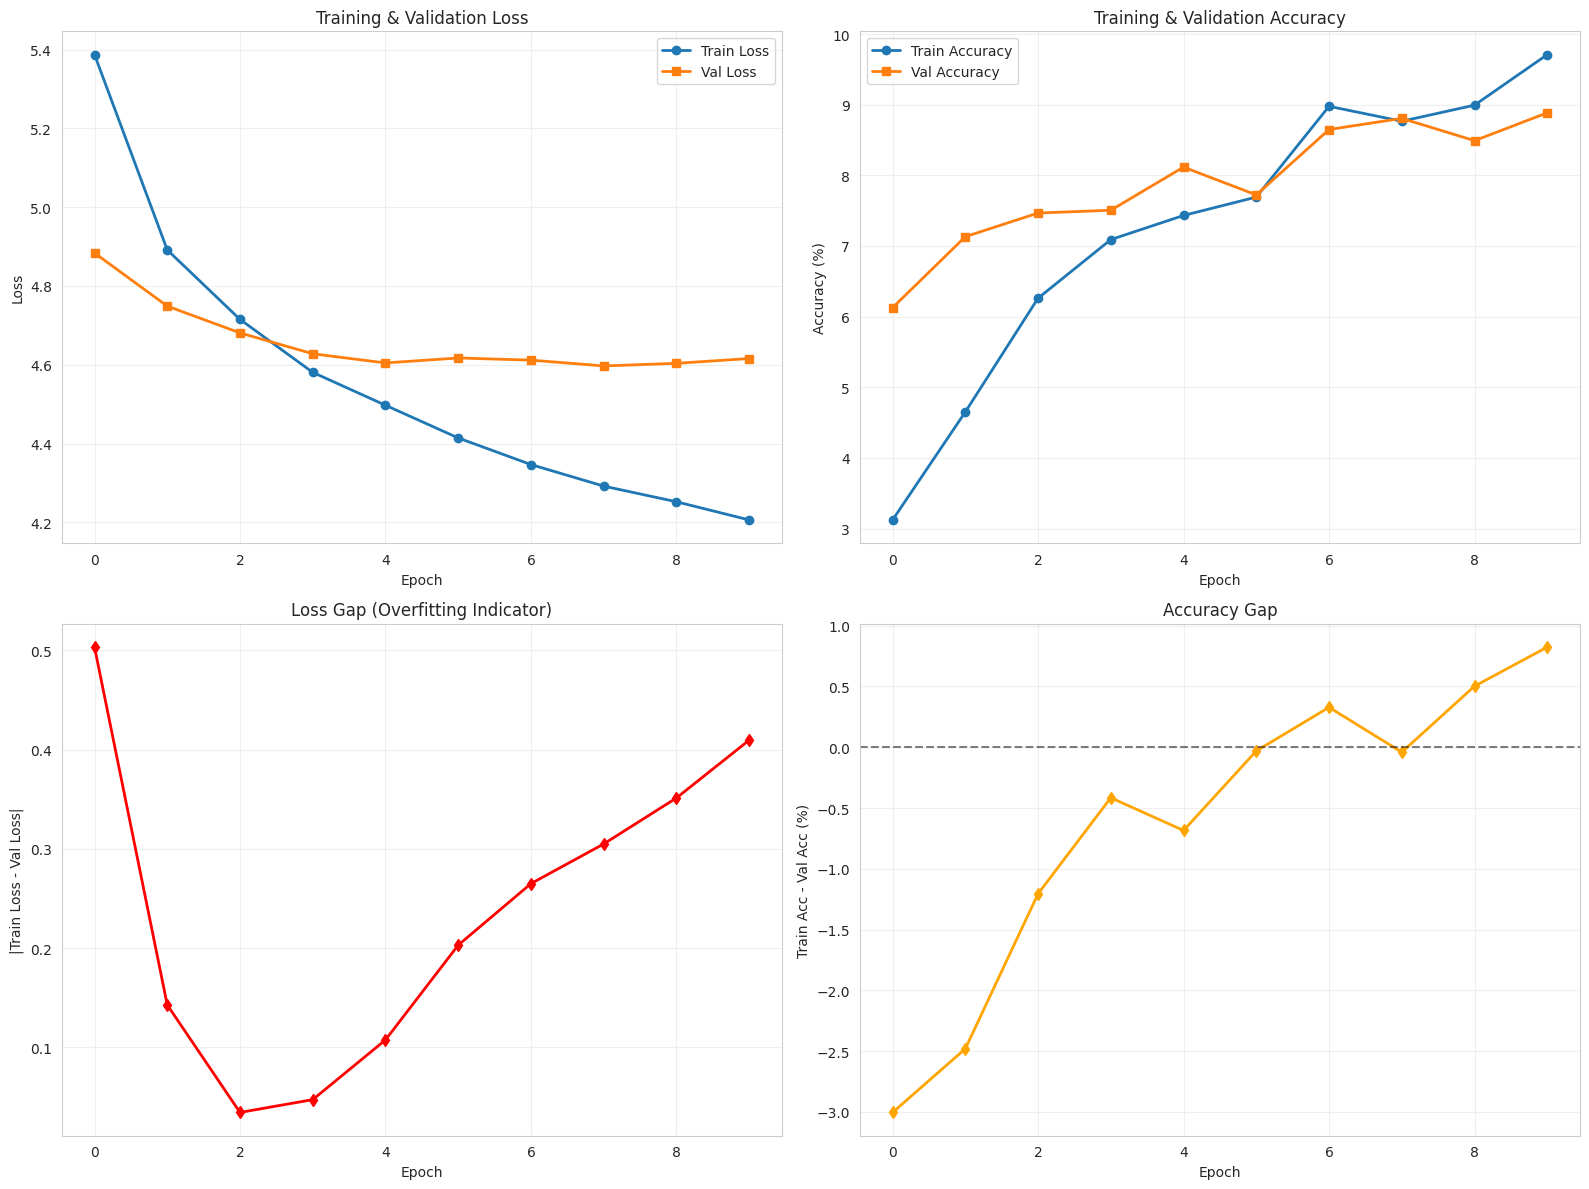


🔍 Running Comprehensive Evaluation...


Evaluating: 100%|██████████| 159/159 [06:30<00:00,  2.46s/it]



FINAL VALIDATION RESULTS
Total Samples: 5076
Correct: 451
Incorrect: 4625
Accuracy: 8.88%

📊 Generating Confusion Matrix...
✓ Saved: confusion_matrix.png


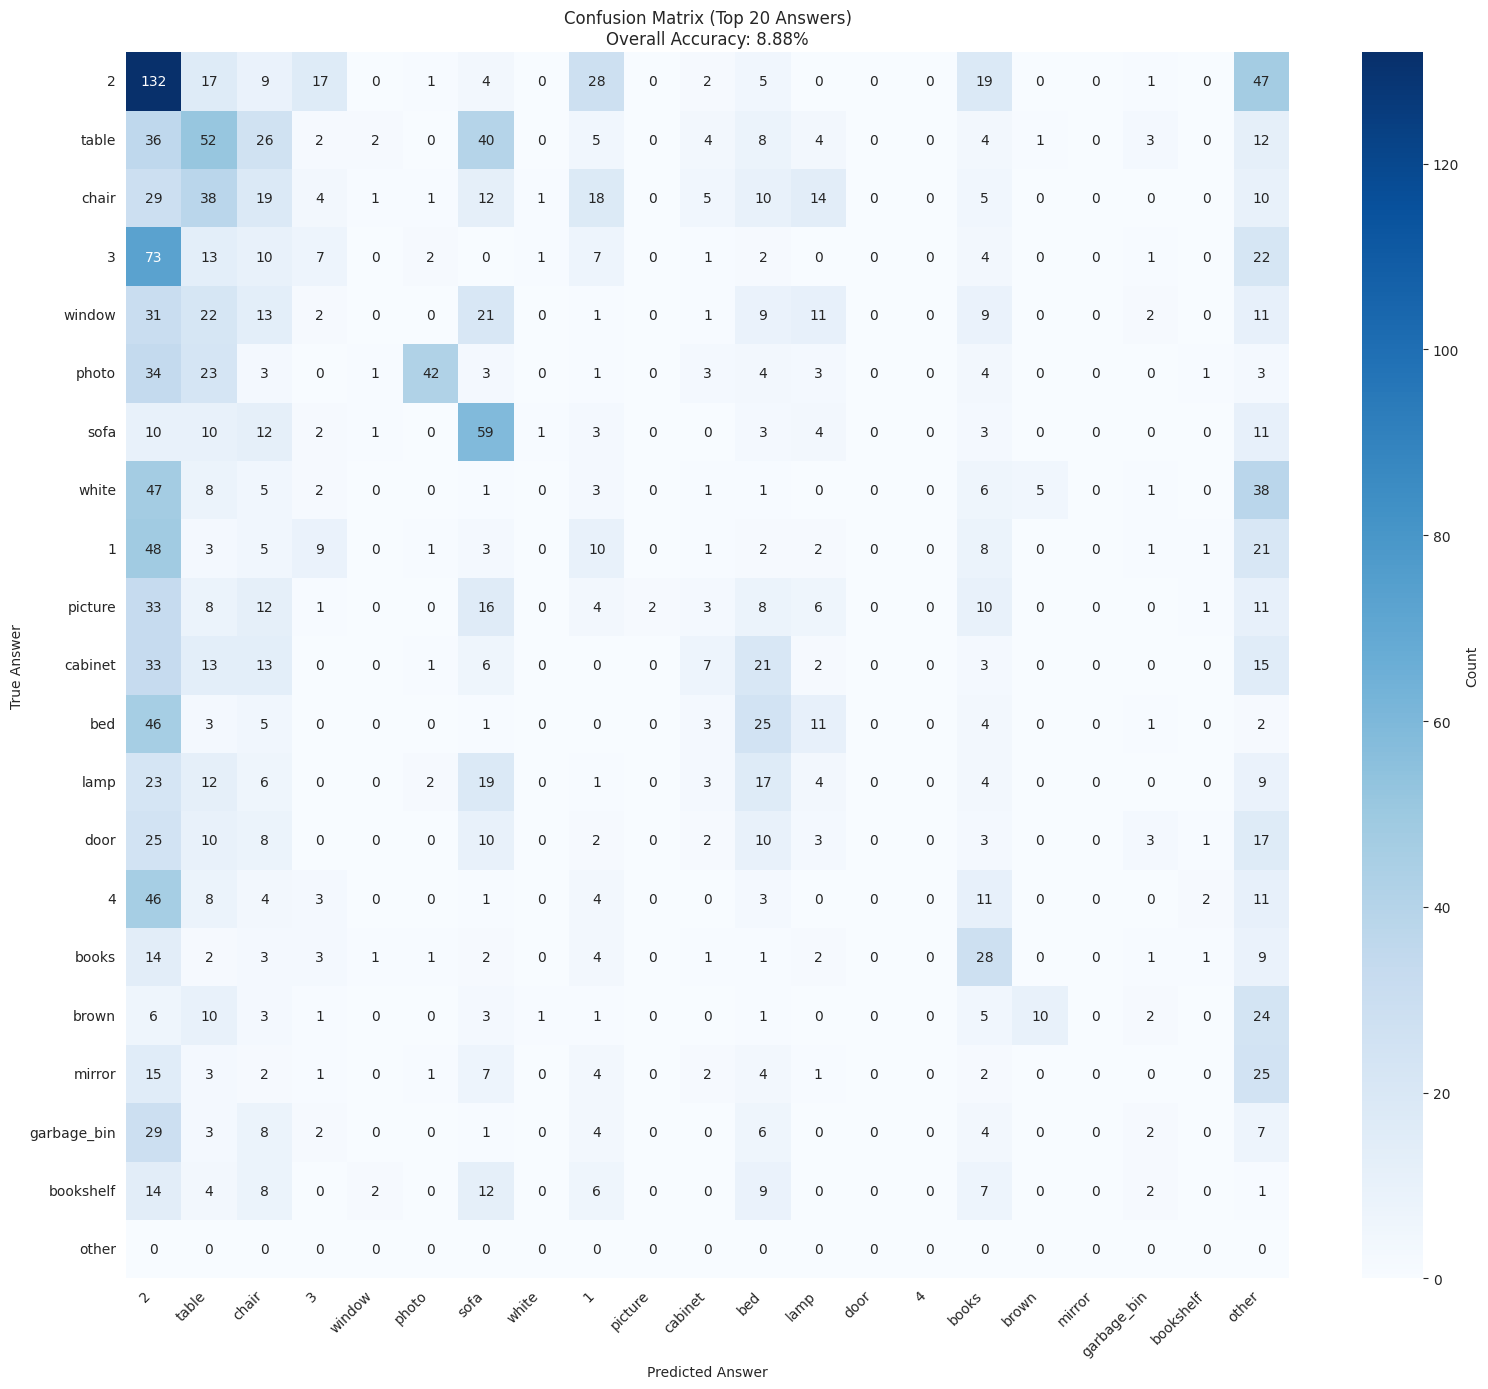

📊 Analyzing Answer Distribution...
✓ Saved: answer_distribution_analysis.png


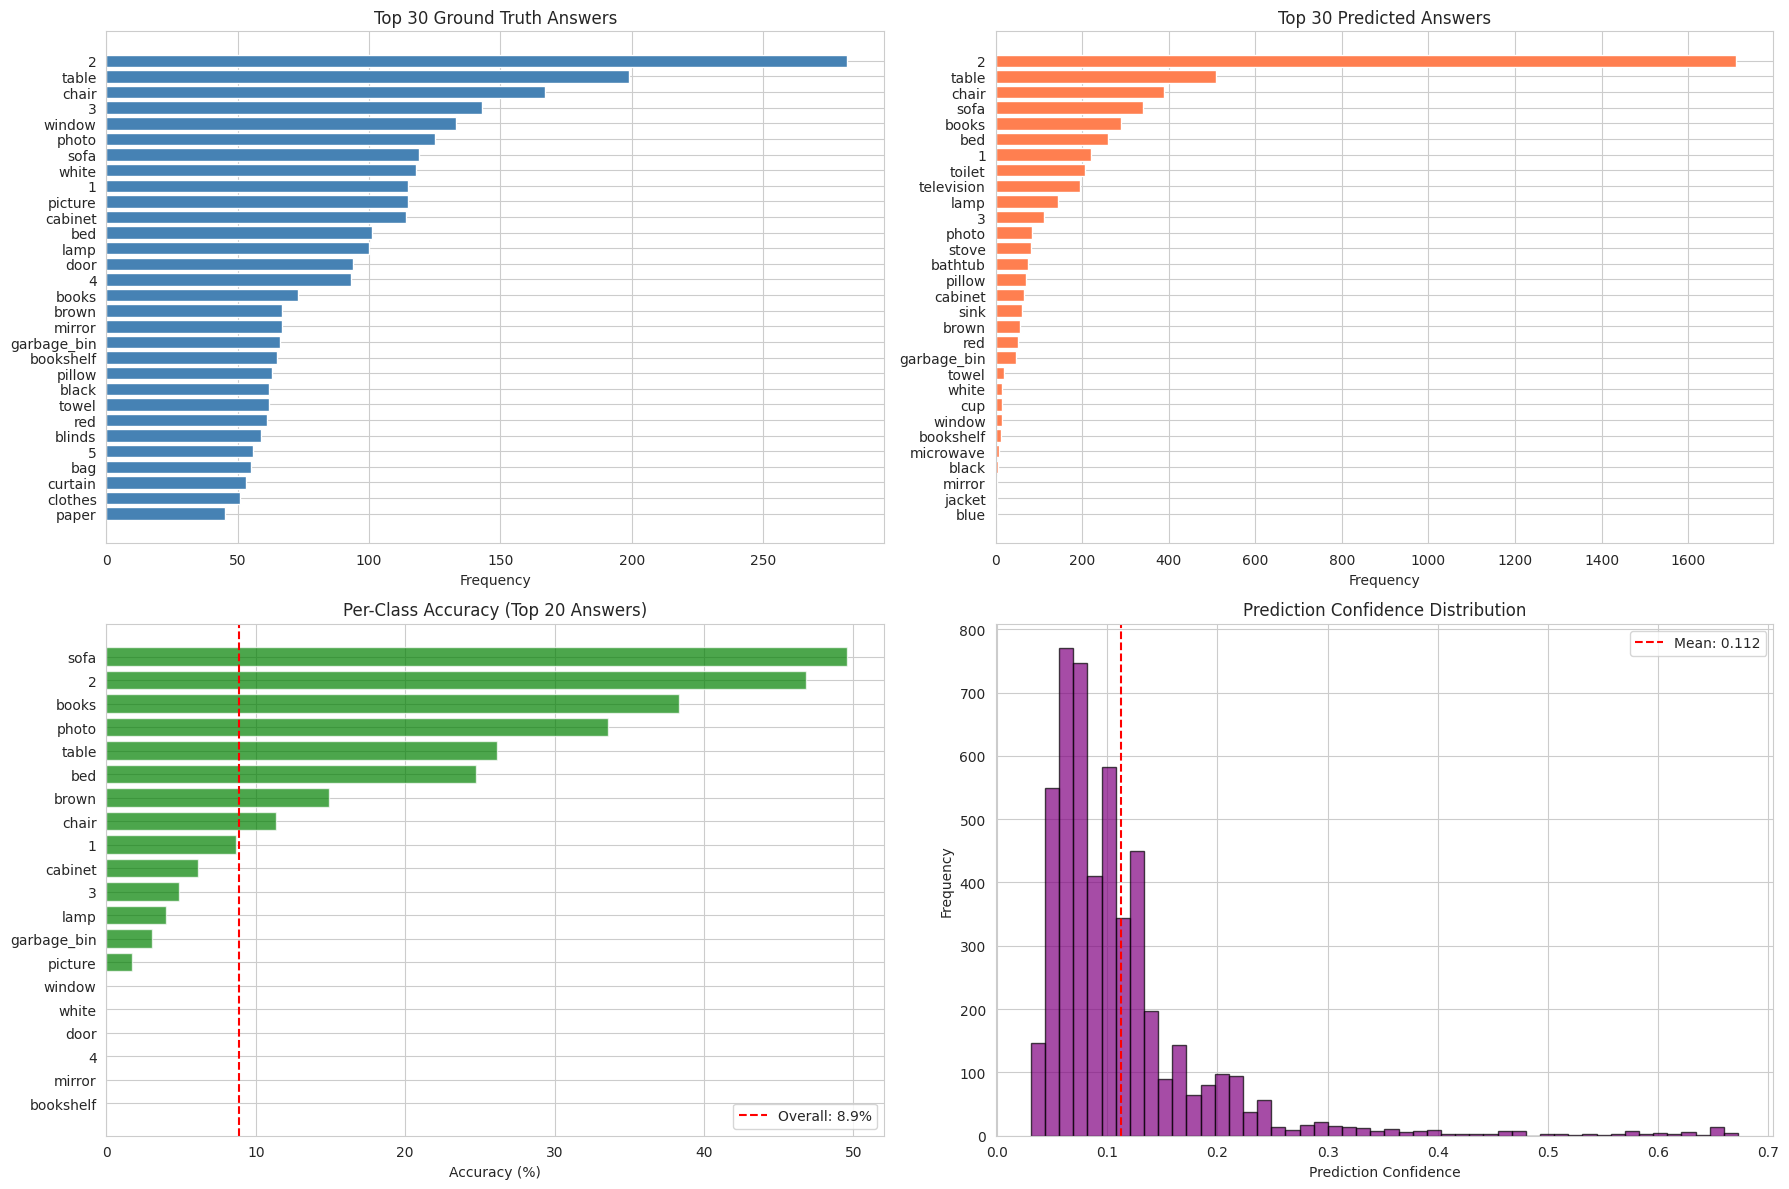

❓ Analyzing Question Types...
✓ Saved: question_type_analysis.png


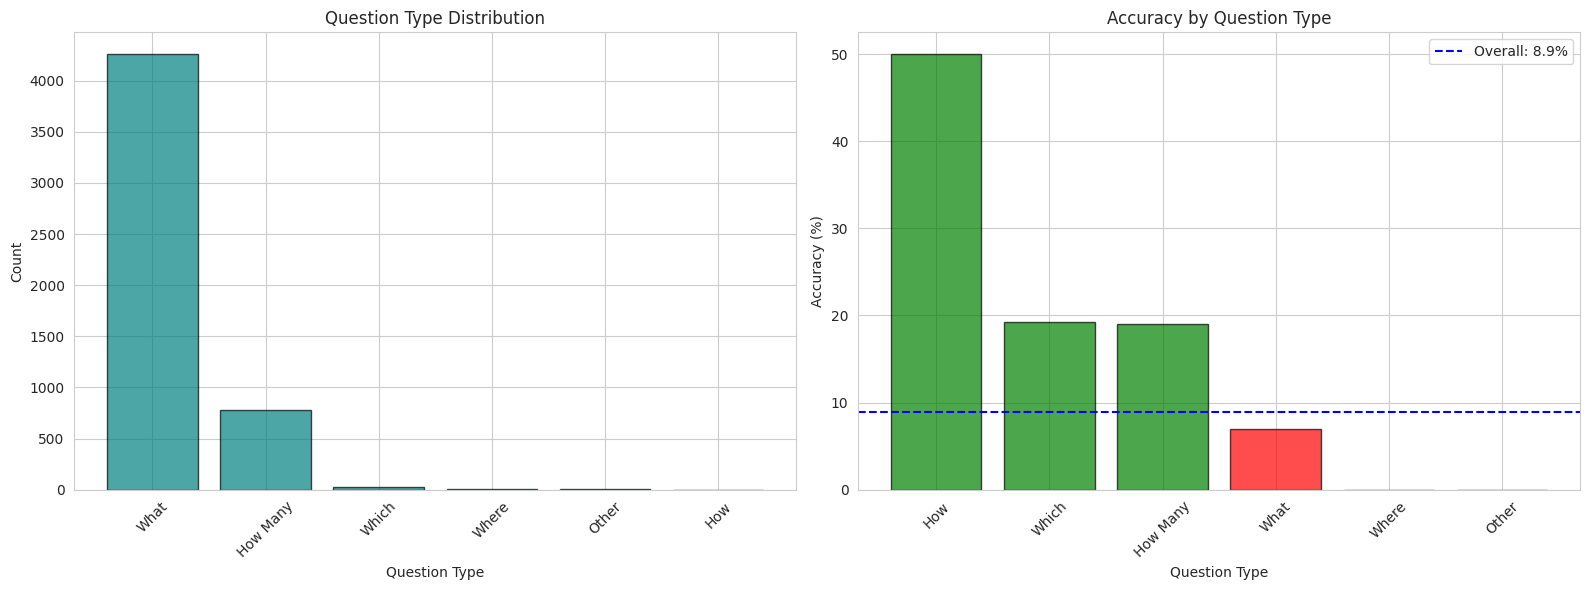

🧠 Analyzing Knowledge Graph Impact...
✓ Saved: knowledge_graph_impact.png


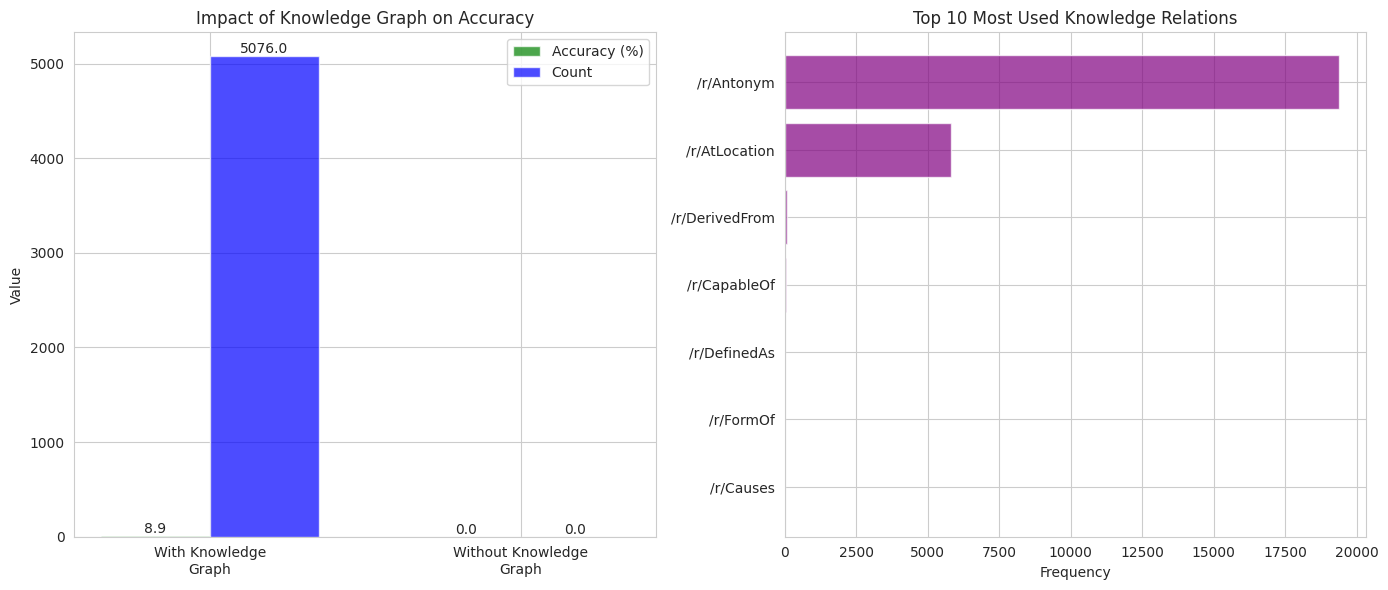


📊 Knowledge Graph Statistics:
  Samples with KG: 5076 (Acc: 8.88%)
  Samples without KG: 0 (Acc: 0.00%)
  KG Impact: +8.88%

🖼️  Generating Visual Prediction Examples...


IndexError: list index out of range

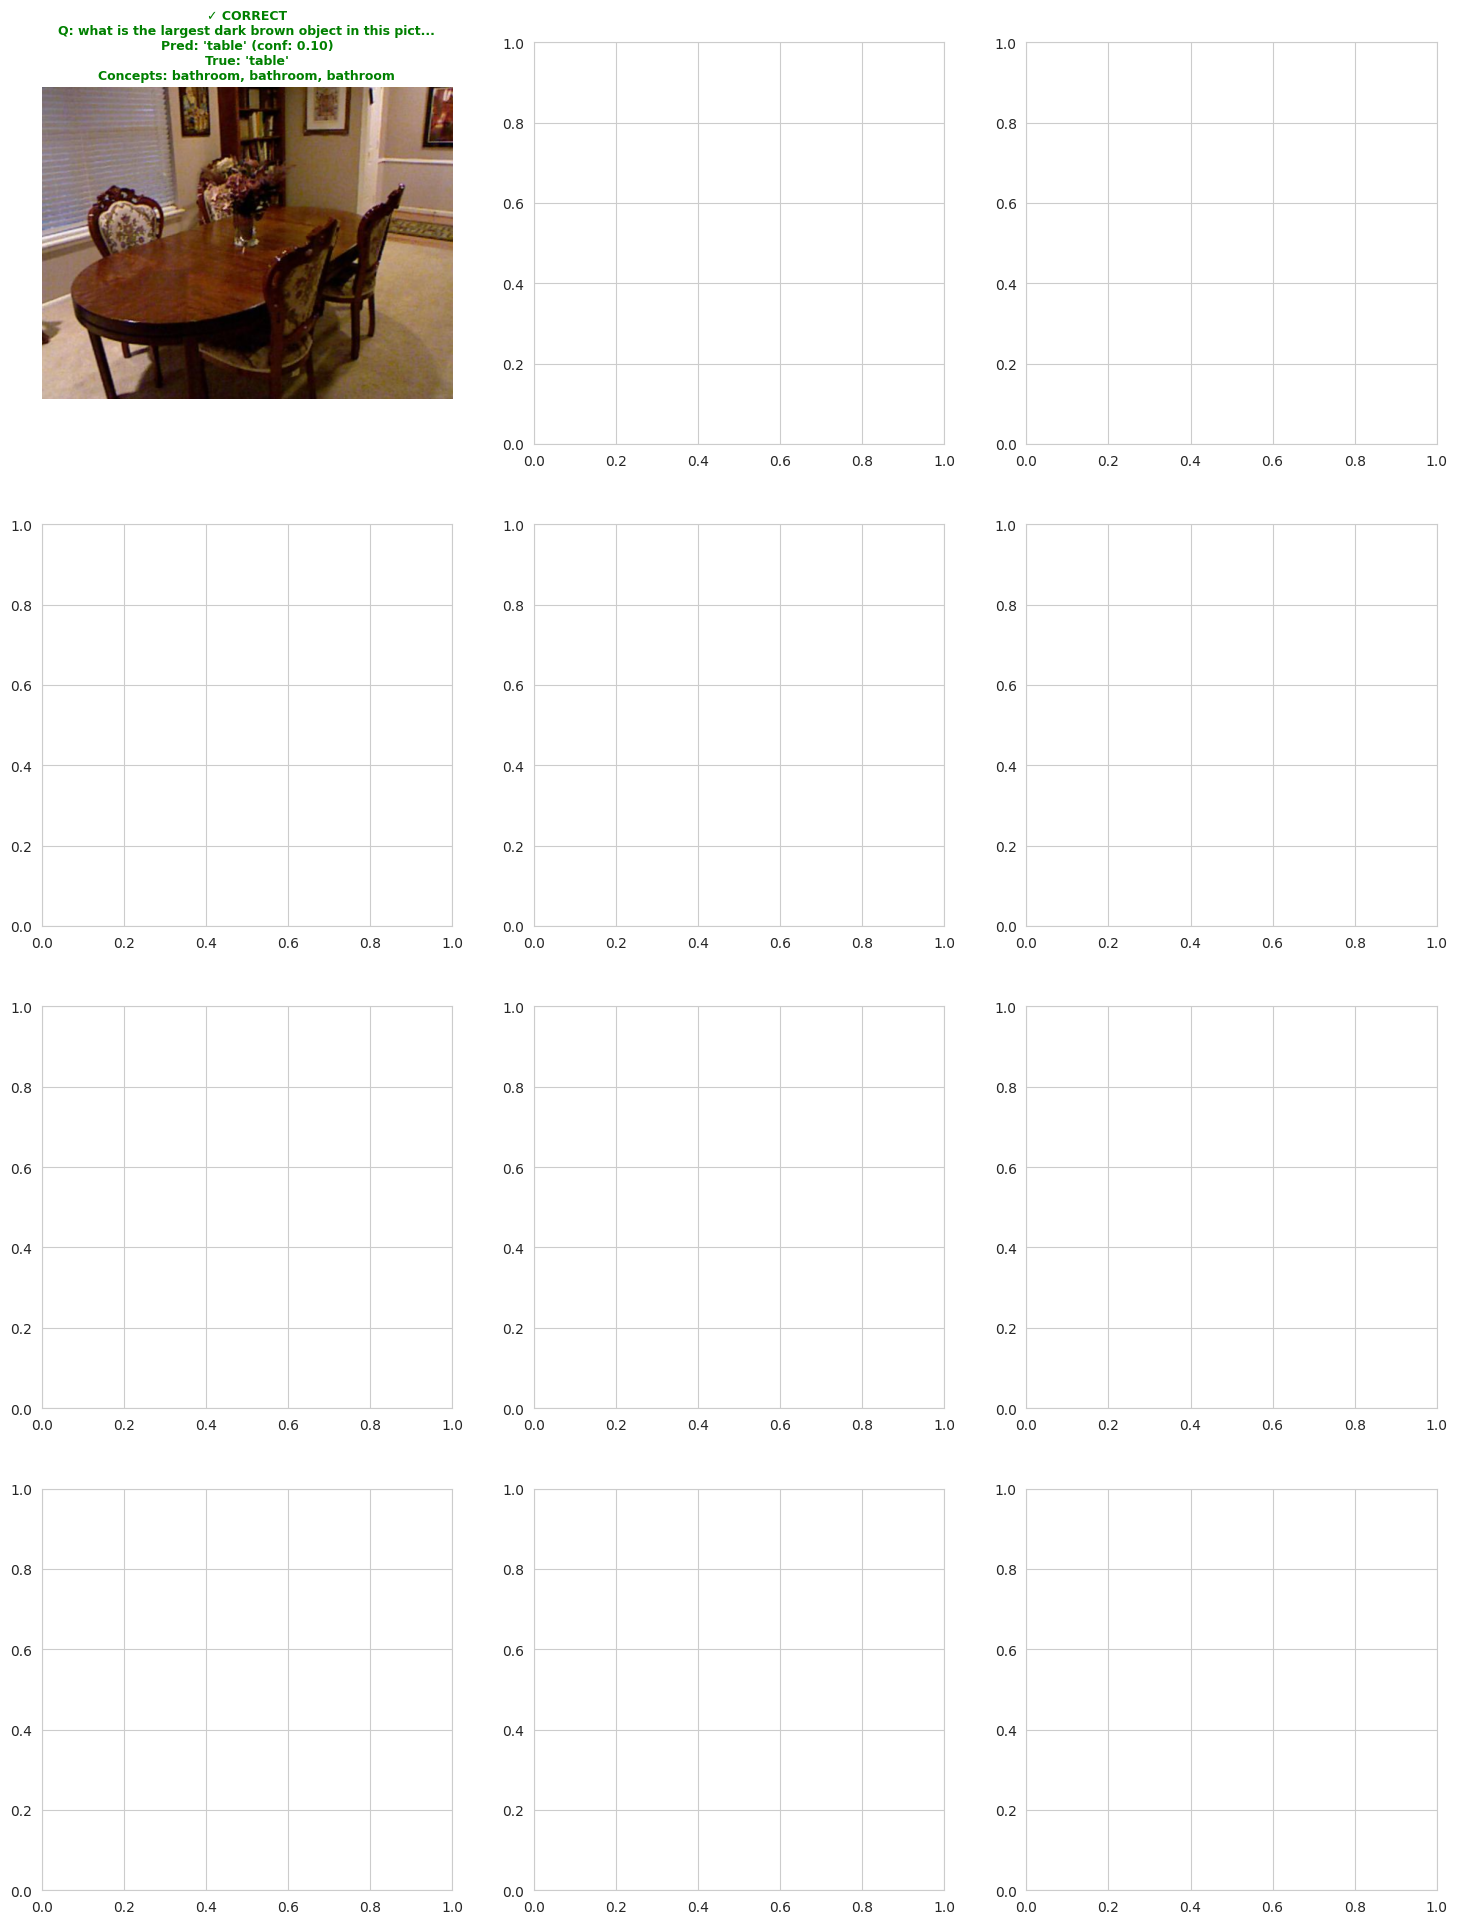

In [8]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from PIL import Image
import os
from tqdm import tqdm
import json

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("="*70)
print("VQA Model Analysis & Visualization Suite")
print("="*70)

# ============================================================================
# 1. TRAINING CURVES
# ============================================================================
print("\n📈 Generating Training Curves...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss curves
axes[0, 0].plot(training_losses, marker='o', label='Train Loss', linewidth=2)
axes[0, 0].plot(val_losses, marker='s', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(training_accs, marker='o', label='Train Accuracy', linewidth=2)
axes[0, 1].plot(val_accs, marker='s', label='Val Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training & Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Loss difference (overfitting indicator)
loss_diff = [abs(t - v) for t, v in zip(training_losses, val_losses)]
axes[1, 0].plot(loss_diff, marker='d', color='red', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('|Train Loss - Val Loss|')
axes[1, 0].set_title('Loss Gap (Overfitting Indicator)')
axes[1, 0].grid(True, alpha=0.3)

# Accuracy difference
acc_diff = [t - v for t, v in zip(training_accs, val_accs)]
axes[1, 1].plot(acc_diff, marker='d', color='orange', linewidth=2)
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Train Acc - Val Acc (%)')
axes[1, 1].set_title('Accuracy Gap')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
print("✓ Saved: training_curves.png")
plt.show()

# ============================================================================
# 2. COMPREHENSIVE EVALUATION ON VALIDATION SET
# ============================================================================
print("\n🔍 Running Comprehensive Evaluation...")

model.eval()
all_predictions = []
all_ground_truths = []
all_questions = []
all_image_ids = []
all_kg_texts = []
all_image_concepts = []
prediction_confidences = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        images = batch['image'].to(device)
        question_tokens = batch['question_tokens'].to(device)
        kg_tokens = batch['kg_tokens'].to(device)
        answers = batch['answer'].to(device)
        
        logits, attn_weights = model(images, question_tokens, kg_tokens)
        
        # Get predictions and confidences
        probs = torch.softmax(logits, dim=1)
        confidences, predictions = torch.max(probs, dim=1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_ground_truths.extend(answers.cpu().numpy())
        all_questions.extend(batch['question_text'])
        all_image_ids.extend(batch['image_id'])
        all_kg_texts.extend(batch['kg_text'])
        all_image_concepts.extend(batch['image_concepts'])
        prediction_confidences.extend(confidences.cpu().numpy())

# Convert to answer strings
pred_answers = [train_dataset.idx_to_answer[p] for p in all_predictions]
true_answers = [train_dataset.idx_to_answer[t] for t in all_ground_truths]

# Calculate accuracy
correct = sum([p == t for p, t in zip(pred_answers, true_answers)])
total = len(pred_answers)
final_accuracy = (correct / total) * 100

print(f"\n{'='*70}")
print(f"FINAL VALIDATION RESULTS")
print(f"{'='*70}")
print(f"Total Samples: {total}")
print(f"Correct: {correct}")
print(f"Incorrect: {total - correct}")
print(f"Accuracy: {final_accuracy:.2f}%")
print(f"{'='*70}\n")

# ============================================================================
# 3. CONFUSION MATRIX (Top 20 Most Common Answers)
# ============================================================================
print("📊 Generating Confusion Matrix...")

# Get top 20 most common answers
answer_counts = Counter(true_answers)
top_20_answers = [ans for ans, _ in answer_counts.most_common(20)]

# Filter predictions and ground truths for top 20
filtered_preds = []
filtered_trues = []
for p, t in zip(pred_answers, true_answers):
    if t in top_20_answers:
        filtered_preds.append(p if p in top_20_answers else 'other')
        filtered_trues.append(t)

# Create confusion matrix
from sklearn.metrics import confusion_matrix

labels = top_20_answers + ['other']
cm = confusion_matrix(filtered_trues, filtered_preds, labels=labels)

# Plot
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Answer')
plt.ylabel('True Answer')
plt.title(f'Confusion Matrix (Top 20 Answers)\nOverall Accuracy: {final_accuracy:.2f}%')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Saved: confusion_matrix.png")
plt.show()

# ============================================================================
# 4. ANSWER DISTRIBUTION ANALYSIS
# ============================================================================
print("📊 Analyzing Answer Distribution...")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top 30 most common ground truth answers
gt_counts = Counter(true_answers)
top_30_gt = gt_counts.most_common(30)
answers_gt, counts_gt = zip(*top_30_gt)

axes[0, 0].barh(range(len(answers_gt)), counts_gt, color='steelblue')
axes[0, 0].set_yticks(range(len(answers_gt)))
axes[0, 0].set_yticklabels(answers_gt)
axes[0, 0].set_xlabel('Frequency')
axes[0, 0].set_title('Top 30 Ground Truth Answers')
axes[0, 0].invert_yaxis()

# Top 30 predicted answers
pred_counts = Counter(pred_answers)
top_30_pred = pred_counts.most_common(30)
answers_pred, counts_pred = zip(*top_30_pred)

axes[0, 1].barh(range(len(answers_pred)), counts_pred, color='coral')
axes[0, 1].set_yticks(range(len(answers_pred)))
axes[0, 1].set_yticklabels(answers_pred)
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_title('Top 30 Predicted Answers')
axes[0, 1].invert_yaxis()

# Per-class accuracy for top 20
class_accuracies = {}
for ans in top_20_answers:
    indices = [i for i, t in enumerate(true_answers) if t == ans]
    if indices:
        correct_for_class = sum([pred_answers[i] == ans for i in indices])
        class_accuracies[ans] = (correct_for_class / len(indices)) * 100

sorted_class_acc = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)
answers_acc, accs = zip(*sorted_class_acc) if sorted_class_acc else ([], [])

axes[1, 0].barh(range(len(answers_acc)), accs, color='green', alpha=0.7)
axes[1, 0].set_yticks(range(len(answers_acc)))
axes[1, 0].set_yticklabels(answers_acc)
axes[1, 0].set_xlabel('Accuracy (%)')
axes[1, 0].set_title('Per-Class Accuracy (Top 20 Answers)')
axes[1, 0].axvline(x=final_accuracy, color='red', linestyle='--', label=f'Overall: {final_accuracy:.1f}%')
axes[1, 0].legend()
axes[1, 0].invert_yaxis()

# Confidence distribution
axes[1, 1].hist(prediction_confidences, bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=np.mean(prediction_confidences), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(prediction_confidences):.3f}')
axes[1, 1].set_xlabel('Prediction Confidence')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Prediction Confidence Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('answer_distribution_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: answer_distribution_analysis.png")
plt.show()

# ============================================================================
# 5. QUESTION TYPE ANALYSIS
# ============================================================================
print("❓ Analyzing Question Types...")

# Categorize questions
def categorize_question(question):
    q_lower = question.lower()
    if q_lower.startswith('what'):
        return 'What'
    elif q_lower.startswith('how many'):
        return 'How Many'
    elif q_lower.startswith('how'):
        return 'How'
    elif q_lower.startswith('where'):
        return 'Where'
    elif q_lower.startswith('is') or q_lower.startswith('are'):
        return 'Yes/No'
    elif q_lower.startswith('which'):
        return 'Which'
    else:
        return 'Other'

question_types = [categorize_question(q) for q in all_questions]
type_accuracy = defaultdict(lambda: {'correct': 0, 'total': 0})

for qtype, pred, true in zip(question_types, pred_answers, true_answers):
    type_accuracy[qtype]['total'] += 1
    if pred == true:
        type_accuracy[qtype]['correct'] += 1

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Question type distribution
type_counts = Counter(question_types)
types, counts = zip(*type_counts.most_common())
ax1.bar(types, counts, color='teal', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Question Type')
ax1.set_ylabel('Count')
ax1.set_title('Question Type Distribution')
ax1.tick_params(axis='x', rotation=45)

# Accuracy by question type
type_accs = {t: (v['correct'] / v['total'] * 100) for t, v in type_accuracy.items()}
sorted_types = sorted(type_accs.items(), key=lambda x: x[1], reverse=True)
types_acc, accs_acc = zip(*sorted_types)

colors = ['green' if acc > final_accuracy else 'red' for acc in accs_acc]
ax2.bar(types_acc, accs_acc, color=colors, alpha=0.7, edgecolor='black')
ax2.axhline(y=final_accuracy, color='blue', linestyle='--', label=f'Overall: {final_accuracy:.1f}%')
ax2.set_xlabel('Question Type')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy by Question Type')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('question_type_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: question_type_analysis.png")
plt.show()

# ============================================================================
# 6. KNOWLEDGE GRAPH IMPACT ANALYSIS
# ============================================================================
print("🧠 Analyzing Knowledge Graph Impact...")

# Separate samples with and without knowledge
has_kg = []
no_kg = []

for i, kg_text in enumerate(all_kg_texts):
    is_correct = pred_answers[i] == true_answers[i]
    if kg_text != "no knowledge" and kg_text.strip() != "":
        has_kg.append(is_correct)
    else:
        no_kg.append(is_correct)

# Calculate accuracies
acc_with_kg = (sum(has_kg) / len(has_kg) * 100) if has_kg else 0
acc_without_kg = (sum(no_kg) / len(no_kg) * 100) if no_kg else 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot
categories = ['With Knowledge\nGraph', 'Without Knowledge\nGraph']
accuracies = [acc_with_kg, acc_without_kg]
counts = [len(has_kg), len(no_kg)]

x = np.arange(len(categories))
width = 0.35

bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy (%)', color=['green', 'orange'], alpha=0.7)
bars2 = ax1.bar(x + width/2, counts, width, label='Count', color=['blue', 'red'], alpha=0.7)

ax1.set_ylabel('Value')
ax1.set_title('Impact of Knowledge Graph on Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')

# Most common knowledge relations
kg_relations = []
for kg_text in all_kg_texts:
    if kg_text != "no knowledge":
        parts = kg_text.split('|')
        for part in parts:
            tokens = part.strip().split()
            if len(tokens) >= 2:
                # Extract relation (middle token)
                relation = tokens[1] if len(tokens) >= 3 else tokens[0]
                kg_relations.append(relation)

if kg_relations:
    rel_counts = Counter(kg_relations)
    top_10_rels = rel_counts.most_common(10)
    rels, rel_cnts = zip(*top_10_rels)
    
    ax2.barh(range(len(rels)), rel_cnts, color='purple', alpha=0.7)
    ax2.set_yticks(range(len(rels)))
    ax2.set_yticklabels(rels)
    ax2.set_xlabel('Frequency')
    ax2.set_title('Top 10 Most Used Knowledge Relations')
    ax2.invert_yaxis()

plt.tight_layout()
plt.savefig('knowledge_graph_impact.png', dpi=300, bbox_inches='tight')
print("✓ Saved: knowledge_graph_impact.png")
plt.show()

print(f"\n📊 Knowledge Graph Statistics:")
print(f"  Samples with KG: {len(has_kg)} (Acc: {acc_with_kg:.2f}%)")
print(f"  Samples without KG: {len(no_kg)} (Acc: {acc_without_kg:.2f}%)")
print(f"  KG Impact: {acc_with_kg - acc_without_kg:+.2f}%")

# ============================================================================
# 7. VISUAL PREDICTIONS - Sample Images with Predictions
# ============================================================================
print("\n🖼️  Generating Visual Prediction Examples...")

# Select diverse samples: some correct, some incorrect
correct_indices = [i for i, (p, t) in enumerate(zip(pred_answers, true_answers)) if p == t]
incorrect_indices = [i for i, (p, t) in enumerate(zip(pred_answers, true_answers)) if p != t]

# Sample 6 correct and 6 incorrect
sample_correct = np.random.choice(correct_indices, min(6, len(correct_indices)), replace=False)
sample_incorrect = np.random.choice(incorrect_indices, min(6, len(incorrect_indices)), replace=False)

fig, axes = plt.subplots(4, 3, figsize=(18, 24))
axes = axes.flatten()

for idx, sample_idx in enumerate(list(sample_correct) + list(sample_incorrect)):
    img_id = all_image_ids[sample_idx]
    question = all_questions[sample_idx]
    pred = pred_answers[sample_idx]
    true = true_answers[sample_idx]
    confidence = prediction_confidences[sample_idx]
    concepts = all_image_concepts[sample_idx]
    kg_text = all_kg_texts[sample_idx]
    
    # Load image
    img_path = os.path.join(IMAGE_DIR, f"{img_id}.png")
    try:
        img = Image.open(img_path).convert('RGB')
    except:
        img = Image.new('RGB', (224, 224), color='gray')
    
    # Display
    axes[idx].imshow(img)
    axes[idx].axis('off')
    
    is_correct = pred == true
    color = 'green' if is_correct else 'red'
    status = '✓ CORRECT' if is_correct else '✗ INCORRECT'
    
    title = f"{status}\n"
    title += f"Q: {question[:50]}{'...' if len(question) > 50 else ''}\n"
    title += f"Pred: '{pred}' (conf: {confidence:.2f})\n"
    title += f"True: '{true}'\n"
    title += f"Concepts: {', '.join(concepts[:3])}"
    
    axes[idx].set_title(title, fontsize=9, color=color, weight='bold')

plt.tight_layout()
plt.savefig('visual_predictions.png', dpi=300, bbox_inches='tight')
print("✓ Saved: visual_predictions.png")
plt.show()

# ============================================================================
# 8. ERROR ANALYSIS
# ============================================================================
print("\n❌ Performing Error Analysis...")

# Find most confused answer pairs
confusion_pairs = Counter()
for pred, true in zip(pred_answers, true_answers):
    if pred != true:
        confusion_pairs[(true, pred)] += 1

print("\n🔀 Top 10 Most Confused Answer Pairs:")
print("─" * 70)
for (true_ans, pred_ans), count in confusion_pairs.most_common(10):
    print(f"  True: '{true_ans}' → Predicted: '{pred_ans}' ({count} times)")

# Low confidence errors vs high confidence errors
low_conf_errors = [(p, t, c, q) for p, t, c, q in zip(pred_answers, true_answers, 
                   prediction_confidences, all_questions) if p != t and c < 0.5]
high_conf_errors = [(p, t, c, q) for p, t, c, q in zip(pred_answers, true_answers,
                    prediction_confidences, all_questions) if p != t and c > 0.8]

print(f"\n🎯 Confidence-based Error Analysis:")
print(f"  Low confidence errors (< 0.5): {len(low_conf_errors)}")
print(f"  High confidence errors (> 0.8): {len(high_conf_errors)}")

if high_conf_errors:
    print(f"\n⚠️  Examples of High-Confidence Errors (Model is very wrong!):")
    print("─" * 70)
    for i, (pred, true, conf, question) in enumerate(high_conf_errors[:5]):
        print(f"{i+1}. Q: {question}")
        print(f"   Predicted: '{pred}' (confidence: {conf:.3f})")
        print(f"   Actual: '{true}'")
        print()

# ============================================================================
# 9. EXPORT DETAILED RESULTS TO CSV
# ============================================================================
print("💾 Exporting detailed results to CSV...")

results_df = pd.DataFrame({
    'image_id': all_image_ids,
    'question': all_questions,
    'question_type': question_types,
    'true_answer': true_answers,
    'predicted_answer': pred_answers,
    'correct': [p == t for p, t in zip(pred_answers, true_answers)],
    'confidence': prediction_confidences,
    'detected_concepts': [', '.join(c) for c in all_image_concepts],
    'knowledge_graph': all_kg_texts
})

results_df.to_csv('detailed_predictions.csv', index=False)
print("✓ Saved: detailed_predictions.csv")

# ============================================================================
# 10. SUMMARY STATISTICS JSON
# ============================================================================
print("📄 Generating summary statistics...")

summary = {
    'model_info': {
        'architecture': 'Knowledge-Augmented VQA with ConceptNet',
        'clip_backbone': 'ViT-B/32',
        'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad),
        'num_epochs': num_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    },
    'dataset_info': {
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'answer_vocab_size': len(answer_vocab)
    },
    'performance': {
        'final_train_accuracy': float(training_accs[-1]),
        'final_val_accuracy': float(val_accs[-1]),
        'best_val_accuracy': float(best_val_acc),
        'final_train_loss': float(training_losses[-1]),
        'final_val_loss': float(val_losses[-1])
    },
    'knowledge_graph_impact': {
        'samples_with_kg': len(has_kg),
        'samples_without_kg': len(no_kg),
        'accuracy_with_kg': float(acc_with_kg),
        'accuracy_without_kg': float(acc_without_kg),
        'kg_improvement': float(acc_with_kg - acc_without_kg)
    },
    'question_type_accuracy': {k: float(v) for k, v in type_accs.items()},
    'top_10_confused_pairs': [
        {'true': true_ans, 'predicted': pred_ans, 'count': int(count)}
        for (true_ans, pred_ans), count in confusion_pairs.most_common(10)
    ]
}

with open('summary_statistics.json', 'w') as f:
    json.dump(summary, f, indent=2)
print("✓ Saved: summary_statistics.json")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print("\n📁 Generated Files:")
print("  1. training_curves.png - Training/validation loss and accuracy")
print("  2. confusion_matrix.png - Top 20 answer confusion matrix")
print("  3. answer_distribution_analysis.png - Answer frequency and per-class accuracy")
print("  4. question_type_analysis.png - Performance by question type")
print("  5. knowledge_graph_impact.png - Impact of ConceptNet knowledge")
print("  6. visual_predictions.png - Sample predictions with images")
print("  7. detailed_predictions.csv - All predictions with metadata")
print("  8. summary_statistics.json - Complete summary statistics")
print("\n✨ All visualizations and analyses saved successfully!")
print("="*70)

Loaded checkpoint: /kaggle/input/daquar/pytorch/default/1/best_vqa_model_daquar.pth
Validation samples: 5076
Model initialized and loaded.

Searching for correct predictions...
Using sample for demo


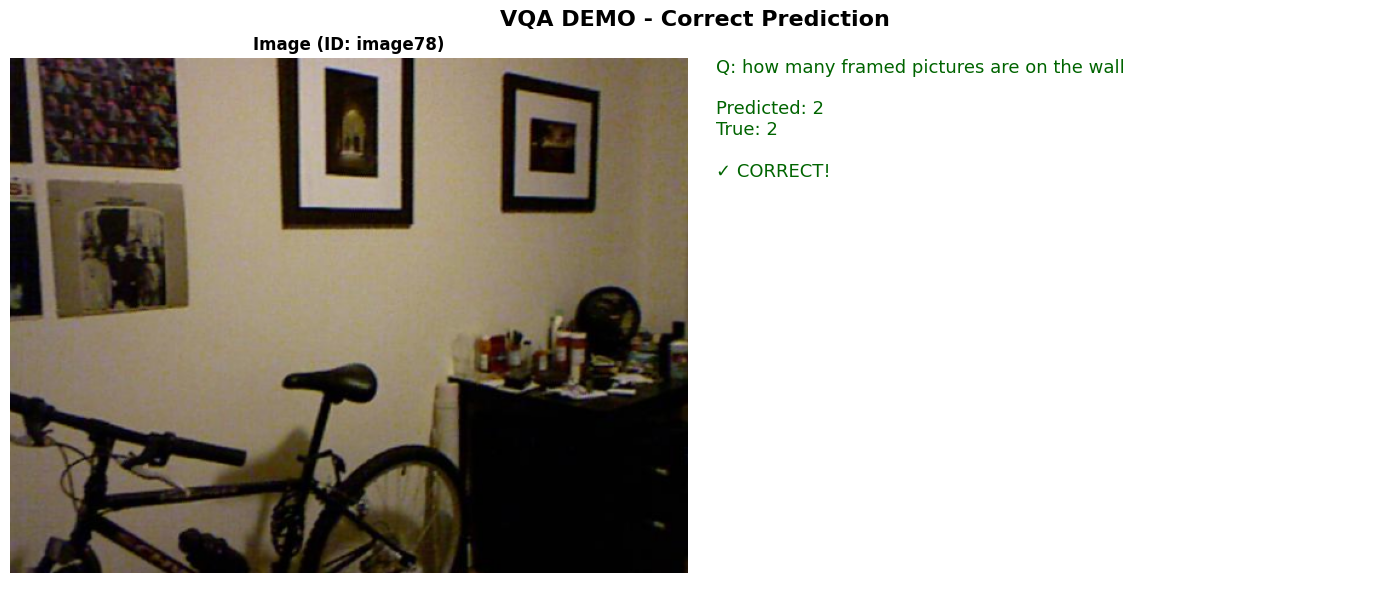


✓ Demo complete!
Saved: vqa_demo_simple.png


In [11]:
# ===========================================================
# FIXED VQA DEMO — SHOW IMAGE, QUESTION, PRED, TRUE
# ===========================================================

import os
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import clip

# ----------------- Paths -----------------
DAQUAR_DIR = "/kaggle/input/processed-daquar-dataset"
EVAL_CSV = f"{DAQUAR_DIR}/data_eval.csv"
ANSWER_VOCAB_FILE = f"{DAQUAR_DIR}/answer_space.txt"
IMAGE_DIR = f"{DAQUAR_DIR}/images"

# Try possible checkpoint locations
PTH_CANDIDATES = [
    "best_vqa_model_daquar.pth",
    "/kaggle/working/best_vqa_model_daquar.pth",
    "/kaggle/input/daquar/pytorch/default/1/best_vqa_model_daquar.pth"
]

MODEL_PTH = None
for p in PTH_CANDIDATES:
    if os.path.exists(p):
        MODEL_PTH = p
        break
if MODEL_PTH is None:
    raise FileNotFoundError("Checkpoint .pth not found. Please set MODEL_PTH manually.")

print("Loaded checkpoint:", MODEL_PTH)

# ----------------- Load CLIP + vocab -----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
clip_model.requires_grad_(False)

with open(ANSWER_VOCAB_FILE, "r") as f:
    answer_vocab = [x.strip() for x in f.readlines()]

# ----------------- Minimal Dataset (NO KG) -----------------
class SimpleDAQUARDataset(Dataset):
    def __init__(self, csv_file, image_dir, preprocess, vocab):
        self.data = pd.read_csv(csv_file)
        self.data = self.data[self.data["answer"].isin(vocab)].reset_index(drop=True)
        self.image_dir = image_dir
        self.preprocess = preprocess
        self.vocab = vocab
        self.answer_to_idx = {a:i for i,a in enumerate(vocab)}
        self.idx_to_answer = {i:a for a,i in self.answer_to_idx.items()}

    def __len__(self): 
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_id = str(row["image_id"])
        question = row["question"]
        answer = row["answer"]

        img_path = os.path.join(self.image_dir, f"{img_id}.png")
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            img = Image.new("RGB", (224,224), color="gray")

        img_tensor = self.preprocess(img)
        q_tokens = clip.tokenize([question], truncate=True).squeeze(0)

        return {
            "img": img_tensor,
            "q_tokens": q_tokens,
            "question": question,
            "true_answer": answer,
            "img_id": img_id
        }

val_dataset = SimpleDAQUARDataset(EVAL_CSV, IMAGE_DIR, preprocess, answer_vocab)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

print("Validation samples:", len(val_dataset))


# ----------------- Model definition (EXACTLY matching training) -----------------
class KnowledgeAugmentedVQA(nn.Module):
    def __init__(self, clip_model, clip_embed_dim, kg_embed_dim, num_heads, num_classes):
        super().__init__()

        self.clip_model = clip_model

        # Visual and textual feature processing
        self.image_linear = nn.Linear(clip_embed_dim, clip_embed_dim)
        self.question_linear = nn.Linear(clip_embed_dim, clip_embed_dim)
        self.kg_linear = nn.Linear(clip_embed_dim, kg_embed_dim)

        # Project KG back to 512D for attention
        self.kg_to_512 = nn.Linear(kg_embed_dim, clip_embed_dim)

        # Cross-attention for image-question
        self.vq_cross_attention = nn.MultiheadAttention(
            clip_embed_dim, num_heads, batch_first=True
        )

        # Knowledge fusion module
        self.knowledge_fusion = nn.MultiheadAttention(
            clip_embed_dim, num_heads, batch_first=True
        )

        # Fusion layers
        self.fusion_layer = nn.Sequential(
            nn.Linear(clip_embed_dim + kg_embed_dim, clip_embed_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.LayerNorm(clip_embed_dim)
        )

        # Answer prediction head
        self.answer_head = nn.Sequential(
            nn.Linear(clip_embed_dim, clip_embed_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(clip_embed_dim // 2, num_classes)
        )

    def forward(self, image_input, question_tokens, kg_tokens):
        batch_size = image_input.size(0)
        
        # Get CLIP features (frozen)
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image_input).float()
            question_features = self.clip_model.encode_text(question_tokens).float()
            kg_features = self.clip_model.encode_text(kg_tokens).float()
        
        # Process through linear layers
        image_feat = self.image_linear(image_features)
        question_feat = self.question_linear(question_features)
        kg_feat_300 = self.kg_linear(kg_features)
        
        # Cross-attention: Image attending to Question
        query = image_feat.unsqueeze(1)
        key = question_feat.unsqueeze(1)
        value = question_feat.unsqueeze(1)
        
        vq_attended, _ = self.vq_cross_attention(query, key, value)
        vq_fused = vq_attended.squeeze(1)
        
        # Project KG features to 512D for attention compatibility
        kg_feat_512 = self.kg_to_512(kg_feat_300)
        
        # Knowledge fusion: Fused VQ attending to KG
        vq_query = vq_fused.unsqueeze(1)
        kg_key = kg_feat_512.unsqueeze(1)
        kg_value = kg_feat_512.unsqueeze(1)
        
        kg_attended, attn_weights = self.knowledge_fusion(vq_query, kg_key, kg_value)
        kg_attended = kg_attended.squeeze(1)
        
        # Final fusion
        combined = torch.cat([kg_attended, kg_feat_300], dim=1)
        fused_features = self.fusion_layer(combined)
        
        # Predict answer
        logits = self.answer_head(fused_features)
        
        return logits, attn_weights


# ----------------- Load trained model -----------------
model = KnowledgeAugmentedVQA(
    clip_model=clip_model,
    clip_embed_dim=512,  # FIXED: was 'clip_dim'
    kg_embed_dim=300,    # FIXED: was 'kg_dim'
    num_heads=8,         # FIXED: was 'heads'
    num_classes=len(answer_vocab)
).to(device)

state = torch.load(MODEL_PTH, map_location=device)
if isinstance(state, dict) and ("state_dict" in state or "model_state_dict" in state):
    state = state["state_dict"] if "state_dict" in state else state["model_state_dict"]

model.load_state_dict(state)
model.eval()

print("Model initialized and loaded.")

# ----------------- Find 2nd CORRECT prediction (skip the first one) -----------------
print("\nSearching for correct predictions...")
correct_samples = []

for idx in range(len(val_dataset)):
    sample = val_dataset[idx]
    
    # Model inference
    img_tensor = sample["img"].unsqueeze(0).to(device)
    q_tokens = sample["q_tokens"].unsqueeze(0).to(device)
    kg_tokens = clip.tokenize(["no knowledge"]).to(device)

    with torch.no_grad():
        logits, _ = model(img_tensor, q_tokens, kg_tokens)
        pred = logits.argmax(dim=1).item()

    pred_ans = answer_vocab[pred]
    true_ans = sample["true_answer"]
    
    # Only keep correct predictions
    if pred_ans == true_ans:
        correct_samples.append(idx)
    
    # Stop once we have 2 correct samples (we'll use the 2nd one)
    if len(correct_samples) >= 2:
        break

if len(correct_samples) < 2:
    print(f"Warning: Only found {len(correct_samples)} correct prediction(s)!")
    idx = correct_samples[0] if correct_samples else 0
else:
    idx = correct_samples[1]  # Use the SECOND correct prediction

print(f"Using sample for demo")

# ----------------- Show DEMO (Single Image) -----------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sample = val_dataset[idx]

img_id = sample["img_id"]
img_path = os.path.join(IMAGE_DIR, f"{img_id}.png")
try: 
    pil_img = Image.open(img_path).convert("RGB")
except:
    pil_img = Image.new("RGB", (224,224), color="gray")

# Model inference (recompute for display)
img_tensor = sample["img"].unsqueeze(0).to(device)
q_tokens = sample["q_tokens"].unsqueeze(0).to(device)
kg_tokens = clip.tokenize(["no knowledge"]).to(device)

with torch.no_grad():
    logits, _ = model(img_tensor, q_tokens, kg_tokens)
    pred = logits.argmax(dim=1).item()

pred_ans = answer_vocab[pred]
true_ans = sample["true_answer"]
question = sample["question"]

# ---- Left panel: image ----
axes[0].imshow(pil_img)
axes[0].axis("off")
axes[0].set_title(f"Image (ID: {img_id})", fontsize=12, weight="bold")

# ---- Right panel: SIMPLE TEXT ----
axes[1].axis("off")

axes[1].text(
    0.02, 0.98,
    f"Q: {question}\n\nPredicted: {pred_ans}\nTrue: {true_ans}\n\n✓ CORRECT!",
    fontsize=13,
    va="top",
    color="darkgreen"
)

plt.suptitle("VQA DEMO - Correct Prediction", fontsize=16, weight="bold")
plt.tight_layout()
plt.savefig("vqa_demo_simple.png", dpi=200, bbox_inches='tight')
plt.show()

print("\n✓ Demo complete!")
print(f"Saved: vqa_demo_simple.png")

In [11]:
import os

def explore_directory(path, max_items=10, max_depth=5, current_depth=0, prefix=""):
    """
    Explore directory structure with truncation.
    
    Args:
        path: Directory path to explore
        max_items: Maximum items to show per directory
        max_depth: Maximum depth to traverse
        current_depth: Current recursion depth
        prefix: Prefix for tree visualization
    """
    if current_depth >= max_depth:
        return
    
    try:
        items = os.listdir(path)
        items.sort()
        
        # Separate directories and files
        dirs = [item for item in items if os.path.isdir(os.path.join(path, item))]
        files = [item for item in items if os.path.isfile(os.path.join(path, item))]
        
        # Show directories first
        total_dirs = len(dirs)
        for i, item in enumerate(dirs[:max_items]):
            is_last = (i == len(dirs[:max_items]) - 1) and len(files) == 0
            connector = "└── " if is_last else "├── "
            print(f"{prefix}{connector}📁 {item}/")
            
            # Recurse into directory
            new_prefix = prefix + ("    " if is_last else "│   ")
            explore_directory(
                os.path.join(path, item),
                max_items=max_items,
                max_depth=max_depth,
                current_depth=current_depth + 1,
                prefix=new_prefix
            )
        
        if total_dirs > max_items:
            print(f"{prefix}    ... ({total_dirs - max_items} more directories)")
        
        # Show files
        total_files = len(files)
        for i, item in enumerate(files[:max_items]):
            is_last = i == len(files[:max_items]) - 1
            connector = "└── " if is_last else "├── "
            
            # Get file size
            file_path = os.path.join(path, item)
            size = os.path.getsize(file_path)
            size_str = format_size(size)
            
            print(f"{prefix}{connector}📄 {item} ({size_str})")
        
        if total_files > max_items:
            print(f"{prefix}    ... ({total_files - max_items} more files)")
            
    except PermissionError:
        print(f"{prefix}[Permission Denied]")
    except Exception as e:
        print(f"{prefix}[Error: {e}]")

def format_size(bytes):
    """Format file size in human-readable format."""
    for unit in ['B', 'KB', 'MB', 'GB']:
        if bytes < 1024.0:
            return f"{bytes:.1f} {unit}"
        bytes /= 1024.0
    return f"{bytes:.1f} TB"

# Usage
print("="*80)
print("OK-VQA DATASET STRUCTURE")
print("="*80)
print()

# Replace with your actual path
OKVQA_PATH = "/kaggle/input/okvqa-dataset"  # or whatever the actual path is

print(f"📁 {OKVQA_PATH}/")
explore_directory(OKVQA_PATH, max_items=10, max_depth=5)

print("\n" + "="*80)
print("STRUCTURE EXPLORATION COMPLETE")
print("="*80)

OK-VQA DATASET STRUCTURE

📁 /kaggle/input/okvqa-dataset/
└── 📁 okvqa-dataset/
    ├── 📁 annotations/
    │   ├── 📄 mscoco_train2014_annotations.json (14.5 MB)
    │   └── 📄 mscoco_val2014_annotations.json (8.1 MB)
    ├── 📁 images/
    │   ├── 📁 train2014/
    │   │   └── 📁 train2014/
    │   │       ├── 📄 COCO_train2014_000000000009.jpg (219.0 KB)
    │   │       ├── 📄 COCO_train2014_000000000025.jpg (191.8 KB)
    │   │       ├── 📄 COCO_train2014_000000000030.jpg (69.8 KB)
    │   │       ├── 📄 COCO_train2014_000000000034.jpg (396.5 KB)
    │   │       ├── 📄 COCO_train2014_000000000036.jpg (254.1 KB)
    │   │       ├── 📄 COCO_train2014_000000000049.jpg (121.7 KB)
    │   │       ├── 📄 COCO_train2014_000000000061.jpg (391.0 KB)
    │   │       ├── 📄 COCO_train2014_000000000064.jpg (215.7 KB)
    │   │       ├── 📄 COCO_train2014_000000000071.jpg (209.2 KB)
    │   │       └── 📄 COCO_train2014_000000000072.jpg (233.5 KB)
    │   │           ... (82773 more files)
    │   └── 📁 val2014/

In [12]:
import json

# Load and inspect the actual structure
print("=== INSPECTING YOUR JSON FILES ===\n")

# Check train questions
with open("/kaggle/input/okvqa-dataset/okvqa-dataset/questions/OpenEnded_mscoco_train2014_questions.json", 'r') as f:
    train_q = json.load(f)
    
print("TRAIN QUESTIONS structure:")
print(f"Keys: {train_q.keys()}")
print(f"First question: {train_q['questions'][0]}")
print()

# Check train annotations
with open("/kaggle/input/okvqa-dataset/okvqa-dataset/annotations/mscoco_train2014_annotations.json", 'r') as f:
    train_ann = json.load(f)
    
print("TRAIN ANNOTATIONS structure:")
print(f"Keys: {train_ann.keys()}")
print(f"First annotation: {train_ann['annotations'][0]}")

=== INSPECTING YOUR JSON FILES ===

TRAIN QUESTIONS structure:
Keys: dict_keys(['license', 'data_subtype', 'task_type', 'questions', 'info', 'data_type'])
First question: {'image_id': 51606, 'question': 'What is the hairstyle of the blond called?', 'question_id': 516065}

TRAIN ANNOTATIONS structure:
Keys: dict_keys(['license', 'data_subtype', 'question_types', 'annotations', 'info', 'data_type'])
First annotation: {'image_id': 51606, 'answer_type': 'other', 'question_type': 'four', 'question_id': 516065, 'answers': [{'answer_id': 1, 'raw_answer': 'pony tail', 'answer_confidence': 'yes', 'answer': 'pony tail'}, {'answer_id': 2, 'raw_answer': 'pony tail', 'answer_confidence': 'yes', 'answer': 'pony tail'}, {'answer_id': 3, 'raw_answer': 'pony tail', 'answer_confidence': 'yes', 'answer': 'pony tail'}, {'answer_id': 4, 'raw_answer': 'pony tail', 'answer_confidence': 'yes', 'answer': 'pony tail'}, {'answer_id': 5, 'raw_answer': 'pony tail', 'answer_confidence': 'yes', 'answer': 'pony tail'

In [15]:
import json
from pathlib import Path

def preview_branch(value, indent=0, max_items=2):
    """Pretty-print preview of lists/dicts with head + last items."""
    spacer = "  " * indent

    if isinstance(value, dict):
        print(f"{spacer}{{dict}} with {len(value)} keys")
        for k, v in list(value.items())[:max_items]:
            print(f"{spacer}  ├── '{k}':")
            preview_branch(v, indent + 2, max_items)
        if len(value) > max_items:
            print(f"{spacer}  └── ... ({len(value)-max_items} more keys)")

    elif isinstance(value, list):
        print(f"{spacer}[list] length = {len(value)}")
        # First items
        for i, item in enumerate(value[:max_items]):
            print(f"{spacer}  ├── [{i}]")
            preview_branch(item, indent + 2, max_items)

        # ... middle omitted
        if len(value) > max_items:
            print(f"{spacer}  ├── ... ({len(value)-2*max_items} omitted)")

        # Last 5 items
        for i, item in enumerate(value[-max_items:], start=len(value)-max_items):
            print(f"{spacer}  ├── [{i}]")
            preview_branch(item, indent + 2, max_items)

    else:
        # Primitive value
        print(f"{spacer}{repr(value)}")


def inspect_json(json_path, max_items=5):
    path = Path(json_path)
    print(f"\n========== Inspecting: {path.name} ==========")

    with open(path, "r") as f:
        data = json.load(f)

    print("\nTop-level structure:")
    preview_branch(data, max_items=max_items)

    print("\n=============================================\n")


# ---------------------------------------------
# Example usage:
inspect_json("/kaggle/input/okvqa-dataset/okvqa-dataset/annotations/mscoco_train2014_annotations.json")
inspect_json("/kaggle/input/okvqa-dataset/okvqa-dataset/questions/OpenEnded_mscoco_train2014_questions.json")



========== Inspecting: mscoco_train2014_annotations.json ==========

Top-level structure:
{dict} with 6 keys
  ├── 'license':
    {dict} with 2 keys
      ├── 'url':
        'http://creativecommons.org/licenses/by/4.0/'
      ├── 'name':
        'Creative Commons Attribution 4.0 International License'
  ├── 'data_subtype':
    'train2014'
  ├── 'question_types':
    {dict} with 11 keys
      ├── 'eight':
        'Plants and Animals'
      ├── 'nine':
        'Science and Technology'
      ├── 'four':
        'Sports and Recreation'
      ├── 'six':
        'Geography, History, Language and Culture'
      ├── 'two':
        'Brands, Companies and Products'
      └── ... (6 more keys)
  ├── 'annotations':
    [list] length = 9009
      ├── [0]
        {dict} with 6 keys
          ├── 'image_id':
            51606
          ├── 'answer_type':
            'other'
          ├── 'question_type':
            'four'
          ├── 'question_id':
            516065
          ├── 'answers':
    